**Train an autoencoder (very similar to autoencoder.ipynb) on several types of histograms and study the combined prediction**

Note: this is quite long and complicated script that is quite flexible in the method of training and testing. It is not so much a fixed and fully worked out tutorial, but rather a development script. In fact, many of the results I showed in "recent" DQM/DC general meetings were obtained with this script.

In [7]:
### imports

# external modules
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import importlib

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)

<module 'GaussianKdeFitter' from '../src/cloudfitters/GaussianKdeFitter.py'>

In [8]:
### define run properties
# in this cell all major run properties are going to be set,
# e.g. what runs to train on and what runs to test on

# define a list of good 'reference' runs (found by eye)
# should be replaced at some point by the reference runs defined by the DQM/DC team.
goodrunsls = {'2017':
              {
                "297056":[[-1]],
                "297177":[[-1]],
                "301449":[[-1]],
              },
              '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
             {  "315267":[[-1]] 
             }}

# define core test set of clearly bad runs (found by eye)
badrunsls = {'2017':
                {
                #"297287":[[-1]],
                #"297288":[[-1]],
                "297289":[[-1]],
                #"299316":[[-1]],
                #"299324":[[-1]],
               # "299326":[[-1]],
               # "301086":[[88,126]] # only bad for size_PXDisk_+1 -> maybe do not use for now (unclear what are real anomalies)
                },
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                {
                #"317479":[[-1]],
                "317480":[[-1]],
                "317481":[[-1]],
                "317482":[[-1]],
                #"319847":[[1,35]]
            }}

# set year to use
year = '2017'

# set histogram names to use 
histnames = ['chargeInner_PXLayer_1',
            'chargeInner_PXLayer_2',
             'chargeInner_PXLayer_3'
            ]

# set whether to train globally or locally
training_mode = 'global'

if training_mode == 'global':
    runsls_training = None # use none to not add a mask for training (can e.g. use DCS-bit on mask)
    runsls_good = None # use none to not add a mask for good runs (can e.g. use templates)
    runsls_bad = badrunsls[year] # predefined bad runs
    print('selected runs/lumisections for training: all')
    
elif training_mode == 'local':
    # train locally on a small set of runs
    # - either on n runs preceding a chosen application run,
    # - or on the run associated as reference to the chosen application run.
    
    # select application run
    available_runs = dfu.get_runs( dfu.select_dcson( csvu.read_csv('../data/DF'+year+'_'+histnames[0]+'.csv') ) )
    run_application = 305351
    run_application_index = available_runs.index(run_application)
    # select training set
    usereference = False
    if usereference:
        run_reference = rru.get_reference_run( run_application, jsonfile='../utils/json_allRunsRefRuns.json' )
        if run_reference<0:
            raise Exception('no valid reference run has been defined for run {}'.format(run_application))
        runsls_training = jsonu.tuplelist_to_jsondict([(run_reference,[-1])])
    else:
        ntraining = 5
        runsls_training = jsonu.tuplelist_to_jsondict([(el,[-1]) for el in available_runs[run_application_index-ntraining:run_application_index]])
    runsls_bad = badrunsls[year]
    runsls_good = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)

selected runs/lumisections for training: all


In [9]:
### read the data based on the configuration defined above

readnew = True
save = False

if readnew:
    
    # add the histograms
    histstruct = HistStruct.HistStruct()
    # loop over the histogram types to take into account
    for histname in histnames:
        print('adding {}...'.format(histname))
        # read the histograms from the csv file
        filename = 'DF'+year+'B_'+histname+'.csv'
        df = csvu.read_csv( filename )
        # in case of local training, we can remove most of the histograms
        if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
            runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
            df = dfu.select_runsls( df, runsls_total )
        histstruct.add_dataframe( df )
    print('found {} histograms'.format(len(histstruct.runnbs)))
    
    # add masks
    histstruct.add_dcsonjson_mask( 'dcson' )
    histstruct.add_goldenjson_mask('golden' )
    histstruct.add_hightstat_mask( 'highstat' )
    if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
    nbadruns = 0
    if runsls_bad is not None:
        histstruct.add_json_mask( 'bad', runsls_bad )
        # special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
    
    if save:
        histstruct.save( 'test.pkl' )
        
if not readnew:
    
    histstruct = HistStruct.HistStruct.load( 'test.pkl' )
    nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
    
print('created a histstruct with the following properties:')
print('- number of histogram types: {}'.format(len(histstruct.histnames)))
print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))
print('- masks: {}'.format(list(histstruct.masks.keys())))

adding chargeInner_PXLayer_1...
adding chargeInner_PXLayer_2...
adding chargeInner_PXLayer_3...
found 28335 histograms
created a histstruct with the following properties:
- number of histogram types: 3
- number of lumisections: 28335
- masks: ['dcson', 'golden', 'highstat', 'bad', 'bad0']


In [10]:
### plot the training and/or test sets
# especially useful if running in local mode to check if training set is relevant for targeted application run,
# and if the application run contains anomalies

skipthiscell = False

if( training_mode=='local' and not skipthiscell ):
    
    # training and application runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','training'],['highstat','good']],
                                labellist = ['training','testing'],
                                colorlist = ['blue','green']
                              )
    
    # application run and bad test runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['bad']],
                                labellist = ['good','bad'],
                                colorlist = ['green','red']
                              )

In [11]:
### extend the training set using artificial data

extendtraining = False

if extendtraining:
    histstruct.exthistograms['training'] = {}
    for histname,hists in histstruct.get_histograms( masknames=['dcson','highstat','training'] ).items():
        print('generating artificial training data for '+histname)
        histstruct.exthistograms['training'][histname] = gdu.upsample_hist_set(hists,5e4)
        print(' -> generated {} histograms'.format(len(histstruct.exthistograms['training'][histname])))

size of training set: (26874, 102)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 51)                5253      
_________________________________________________________________
dense_1 (Dense)              (None, 102)               5304      
Total params: 10,557
Trainable params: 10,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
49/49 [==============================] - 0s 7ms/step - loss: 2.5241e-04 - val_loss: 5.3638e-05
Epoch 2/40
49/49 [==============================] - 0s 4ms/step - loss: 7.5057e-05 - val_loss: 3.0841e-05
Epoch 3/40
49/49 [==============================] - 0s 3ms/step - loss: 4.8663e-05 - val_loss: 1.9518e-05
Epoch 4/40
49/49 [==============================] - 0s 3ms/step - loss: 3.0564e-05 - val_loss: 1.6833e-05
Epoch 5/40
49/49 [==============================] - 0s 

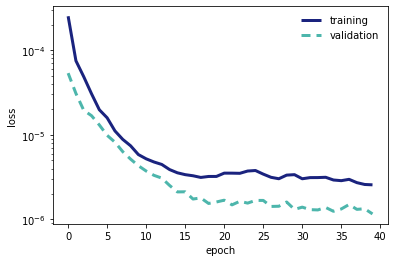

size of training set: (26874, 102)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 51)                5253      
_________________________________________________________________
dense_3 (Dense)              (None, 102)               5304      
Total params: 10,557
Trainable params: 10,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
49/49 [==============================] - 0s 6ms/step - loss: 5.0499e-04 - val_loss: 6.0930e-05
Epoch 2/40
49/49 [==============================] - 0s 3ms/step - loss: 3.3051e-05 - val_loss: 4.9239e-05
Epoch 3/40
49/49 [==============================] - 0s 3ms/step - loss: 2.7833e-05 - val_loss: 4.2896e-05
Epoch 4/40
49/49 [==============================] - 0s 3ms/step - loss: 2.4519e-05 - val_loss: 3.8902e-05
Epoch 5/40
49/49 [==============================] - 0

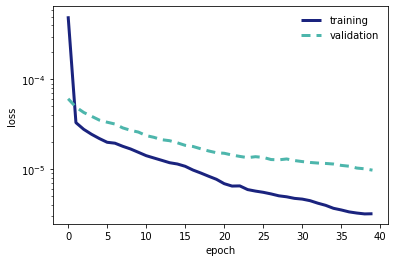

size of training set: (26874, 102)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 51)                5253      
_________________________________________________________________
dense_5 (Dense)              (None, 102)               5304      
Total params: 10,557
Trainable params: 10,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
49/49 [==============================] - 0s 6ms/step - loss: 7.2119e-04 - val_loss: 6.5825e-05
Epoch 2/40
49/49 [==============================] - 0s 3ms/step - loss: 1.3995e-05 - val_loss: 6.3484e-05
Epoch 3/40
49/49 [==============================] - 0s 3ms/step - loss: 1.0566e-05 - val_loss: 5.6658e-05
Epoch 4/40
49/49 [==============================] - 0s 3ms/step - loss: 1.0391e-05 - val_loss: 5.0692e-05
Epoch 5/40
49/49 [==============================] - 0

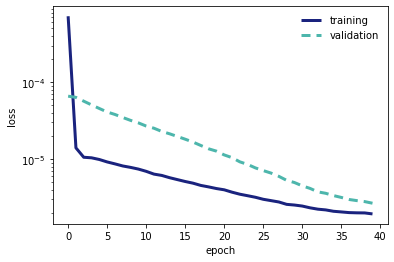

In [12]:
### define and train an autoencoder for each element

from keras.models import load_model

trainnew = True

if trainnew:
    for histname,hists in histstruct.get_histograms( masknames=['dcson','highstat'] ).items():
        if extendtraining: hists = histstruct.exthistograms['training'][histname]
        print('size of training set: {}'.format(hists.shape))
        nepochs = 40 # manual number of epochs
        model = aeu.train_simple_autoencoder(hists,nepochs=nepochs,modelname='')
        classifier = AutoEncoder.AutoEncoder( model=model )
        histstruct.add_classifier(histname,classifier)

In [15]:
### evaluate the models on all histograms in the (non-extended) histstruct

mse_train = []
mse_good = []
mse_bad = []
for i in range(nbadruns): mse_bad.append([])
for histname in histstruct.histnames:
    print('evaluating model for '+histname)
    histstruct.evaluate_classifier(histname)
    # get mse for training set
    if 'training' in histstruct.masks.keys():
        thismse = histstruct.get_scores( histname=histname, masknames=['dcson','highstat', 'training'] )
    else:
        thismse = histstruct.get_scores( histname=histname, masknames=['dcson','highstat'] )
    mse_train.append( thismse )
    # get mse for good set
    if 'good' in histstruct.masks.keys(): 
        thismse = histstruct.get_scores( histname=histname, masknames=['dcson','highstat','good'] )
    else:
        hists_good = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
        thismse = histstruct.classifiers[histname].evaluate( hists_good )
    mse_good.append( thismse )
    # get mse for bad sets
    for i in range(nbadruns):
        thismse = histstruct.get_scores( histname=histname, masknames=['dcson','highstat','bad{}'.format(i)] )
        mse_bad[i].append( thismse )
        
# transform to arrays with correct shape
mse_train = np.array(mse_train)
mse_train = np.transpose(mse_train)
print('found mse array for training set of following shape: {}'.format(mse_train.shape))
mse_good = np.array(mse_good)
mse_good = np.transpose(mse_good)
print('found mse array for good set of following shape: {}'.format(mse_good.shape))
for i in range(nbadruns):
    mse_bad[i] = np.array(mse_bad[i])
    mse_bad[i] = np.transpose(mse_bad[i])
    print('found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))

evaluating model for chargeInner_PXLayer_1
evaluating model for chargeInner_PXLayer_2
evaluating model for chargeInner_PXLayer_3
found mse array for training set of following shape: (26874, 3)
found mse array for good set of following shape: (1000, 3)
found mse array for bad set of following shape: (15, 3)


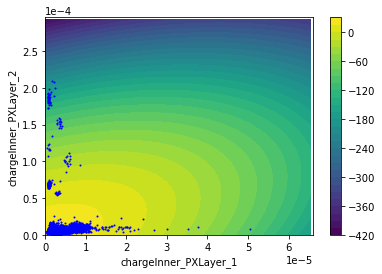

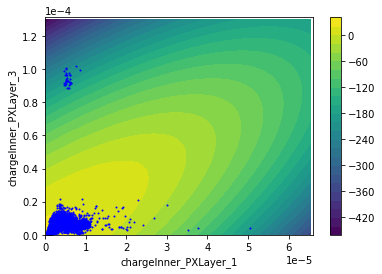

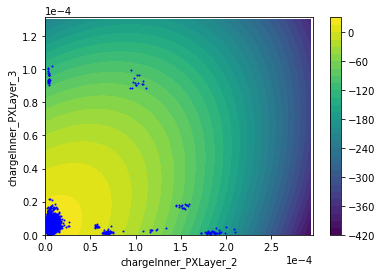

In [14]:
### plot the multidemensional mse and fit a distribution

dimslist = []
fitfunclist = []
nhisttypes = len(histstruct.histnames)
for i in range(0,nhisttypes-1):
    for j in range(i+1,nhisttypes):
        dimslist.append((i,j))

plt.close('all')
(npoints,ndims) = mse_train.shape
scott_bw = npoints**(-1./(ndims+4))
bw_method = 20*scott_bw
for dims in dimslist:
   
    thismse = mse_train[:,dims]
    if training_mode=='global': fitfunc = SeminormalFitter.SeminormalFitter(thismse)
    else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
    pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, onlycontour=False, xlims=30, ylims=30, 
                    onlypositive=True, xaxtitle=histstruct.histnames[dims[0]], 
                    yaxtitle=histstruct.histnames[dims[1]])
    #plt.close('all') # release plot memory
    fitfunclist.append(fitfunc)
    
if training_mode=='global': fitfunc = SeminormalFitter.SeminormalFitter(mse_train)
else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(mse_train,bw_method=bw_method)

In [16]:
### extend the test set using artificial data generation and evaluate the model on the extended test set

skipthiscell = False # to prevent running this cell by accident

if not skipthiscell:
    
    histstruct.exthistograms['good'] = {}
    for i in range(nbadruns): histstruct.exthistograms['bad{}'.format(i)] = {}
    for histname in histstruct.histnames:
        print('generating data for '+histname)
        if 'good' in histstruct.masks.keys():
            goodhists = histstruct.get_histograms( histname=histname,masknames=['dcson','highstat','good'] )
        else:
            goodhists = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat'] ), 15 )
        histstruct.exthistograms['good'][histname] = gdu.upsample_hist_set( goodhists,
                                                    figname='',ntarget=nbadruns*5e3,fourierstdfactor=20.)
        # alternative: copy original good set (e.g. for using resampled bad but original good)
        #histstruct.exthistograms['good'][name] = goodhists
        for i in range(nbadruns):
            badhists = histstruct.get_histograms( histname=histname,masknames=['dcson','bad{}'.format(i)] )
            histstruct.exthistograms['bad{}'.format(i)][histname] = gdu.upsample_hist_set(
                badhists,figname='',ntarget=5e3,fourierstdfactor=20.)
            
    mse_good_ext = []
    mse_bad_ext = []
    for i in range(nbadruns): mse_bad_ext.append( [] )

    for histname in histstruct.histnames:
        print('evaluating: '+histname)
        # calculate mse for good test set
        mse = histstruct.classifiers[histname].evaluate( histstruct.exthistograms['good'][histname] )
        mse_good_ext.append(mse)
        for i in range(nbadruns):
            # calculate mse
            mse = histstruct.classifiers[histname].evaluate( histstruct.exthistograms['bad{}'.format(i)][histname] )
            mse_bad_ext[i].append(mse)
    
    # transform to arrays with correct shape
    mse_good_ext = np.array(mse_good_ext)
    mse_good_ext = np.transpose(mse_good_ext)
    print('found mse array for good set of following shape: {}'.format(mse_good_ext.shape))
    for i in range(nbadruns):
        mse_bad_ext[i] = np.array(mse_bad_ext[i])
        mse_bad_ext[i] = np.transpose(mse_bad_ext[i])
        print('found mse array for bad set of following shape: {}'.format(mse_bad_ext[i].shape))

generating data for chargeInner_PXLayer_1
generating data for chargeInner_PXLayer_2
generating data for chargeInner_PXLayer_3
evaluating: chargeInner_PXLayer_1
evaluating: chargeInner_PXLayer_2
evaluating: chargeInner_PXLayer_3
found mse array for good set of following shape: (4995, 3)
found mse array for bad set of following shape: (4995, 3)


In [21]:
### (re-)define the test set

use_ext = False

mse_good_eval = mse_good
mse_bad_eval = mse_bad
if use_ext:
    mse_good_eval = mse_good_ext
    mse_bad_eval = mse_bad_ext
    
# subselect only specific bad sets for quick checking
# note: not very clean, e.g. watch out with using nbadsets after this cell...
mse_bad_eval = [mse_bad_eval[0]]

../utils/plot_utils.py:379: RuntimeWarning: divide by zero encountered in log
  if logprob: evalpoints = np.log(evalpoints)
../utils/plot_utils.py:379: RuntimeWarning: divide by zero encountered in log
  if logprob: evalpoints = np.log(evalpoints)
../utils/plot_utils.py:379: RuntimeWarning: divide by zero encountered in log
  if logprob: evalpoints = np.log(evalpoints)


--- good lumesections ---
length of log prob array: 1000
minimum of log prob: 0.2635910179323133
--- bad lumisections ---
length of log prob array: 15
maximum of log prob: -169.14211288513417


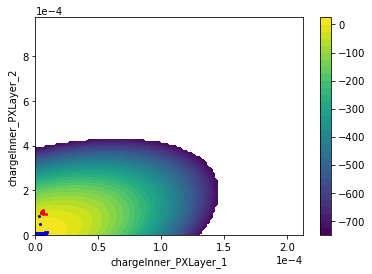

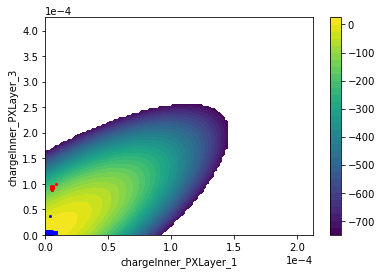

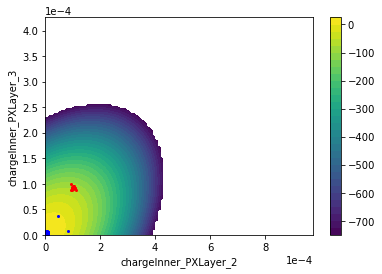

In [22]:
### make a new plot of probability contours and overlay data points
### (only 2D projections!)  

plt.close('all')
colorlist = ['red','lightcoral','firebrick','chocolate','fuchsia','orange','purple']
#colorlist = ['red']*nbadsets
if len(colorlist)<len(mse_bad_eval):
    raise Exception('ERROR: need more colors...')

for dims,partialfitfunc in zip(dimslist,fitfunclist):
    fig,ax = pu.plot_fit_2d(mse_train[:,dims], fitfunc=partialfitfunc, logprob=True, onlycontour=True, 
                            xlims=100, ylims=100, 
                    onlypositive=True, xaxtitle=histstruct.histnames[dims[0]], 
                    yaxtitle=histstruct.histnames[dims[1]])
    for j in range(len(mse_bad_eval)): ax.plot(mse_bad_eval[j][:,dims[0]],mse_bad_eval[j][:,dims[1]],
                                               '.',color=colorlist[j],markersize=4)
    ax.plot(mse_good_eval[:,dims[0]],mse_good_eval[:,dims[1]],'.',color='blue',markersize=4)
    

# get the minimum log probability of histograms in good set
print('--- good lumesections ---')
logprob_good = np.log(fitfunc.pdf(mse_good_eval))
print('length of log prob array: '+str(len(logprob_good)))
print('minimum of log prob: '+str(np.min(logprob_good)))
#print(sorted(logprob_good))
print('--- bad lumisections ---')
logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]
#for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
logprob_bad = np.concatenate(tuple(logprob_bad_parts))
print('length of log prob array: '+str(len(logprob_bad)))
print('maximum of log prob: '+str(np.max(logprob_bad)))
#print(sorted(logprob_good))
#print(sorted(logprob_bad))
#print(logprob_bad)

logprobs of -inf were reset to -215.1404978947599


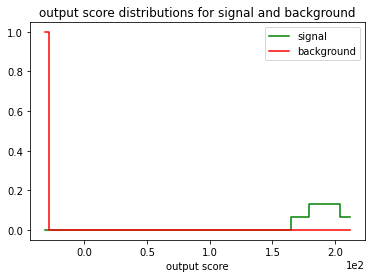

calculating roc curve:
  threshold: 1.0000e+00, signal: 1.0000, background: 1.0000
  threshold: 1.0573e+00, signal: 1.0000, background: 0.8050
  threshold: 1.1179e+00, signal: 1.0000, background: 0.6600
  threshold: 1.1820e+00, signal: 1.0000, background: 0.5890
  threshold: 1.2497e+00, signal: 1.0000, background: 0.4760
  threshold: 1.3213e+00, signal: 1.0000, background: 0.4290
  threshold: 1.3970e+00, signal: 1.0000, background: 0.3670
  threshold: 1.4771e+00, signal: 1.0000, background: 0.3340
  threshold: 1.5617e+00, signal: 1.0000, background: 0.2670
  threshold: 1.6512e+00, signal: 1.0000, background: 0.2090
  threshold: 1.7458e+00, signal: 1.0000, background: 0.1590
  threshold: 1.8459e+00, signal: 1.0000, background: 0.1320
  threshold: 1.9516e+00, signal: 1.0000, background: 0.1230
  threshold: 2.0635e+00, signal: 1.0000, background: 0.1130
  threshold: 2.1817e+00, signal: 1.0000, background: 0.1050
  threshold: 2.3067e+00, signal: 1.0000, background: 0.0960
  threshold: 2.43

../utils/autoencoder_utils.py:199: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim((ylowlim,1+(1-ylowlim)/5))


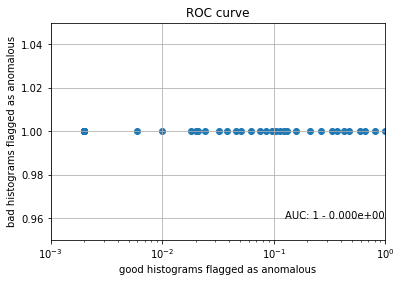

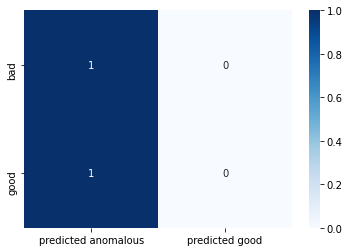

In [28]:
### make a roc curve based on the test results above
# note: smaller logprob = less probable = more outlier = more anomalous
# so if anomalies are signal and good histograms are background, -logprob is a suitable score definition,
# since everything above a certain threshold will be considered signal and below it background.

labels_good = np.zeros(len(logprob_good)) # background: label = 0
labels_bad = np.ones(len(logprob_bad)) # signal: label = 1

labels = np.concatenate(tuple([labels_good,labels_bad]))
scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
maxnoninf = np.max(np.where(scores==np.inf,np.min(scores),scores)) + 1
scores = np.where(scores==np.inf,maxnoninf,scores)
print('logprobs of -inf were reset to {}'.format(-maxnoninf))

pu.plot_score_dist(scores,labels,nbins=50, normalize=True)

auc = aeu.get_roc(scores, labels, mode='geom', doprint=True)

logprob_threshold = 100 # everything below this logprob will be considered signal (i.e. anomalous)
aeu.get_confusion_matrix(scores,labels,-logprob_threshold)

plotting 45 lumisections...


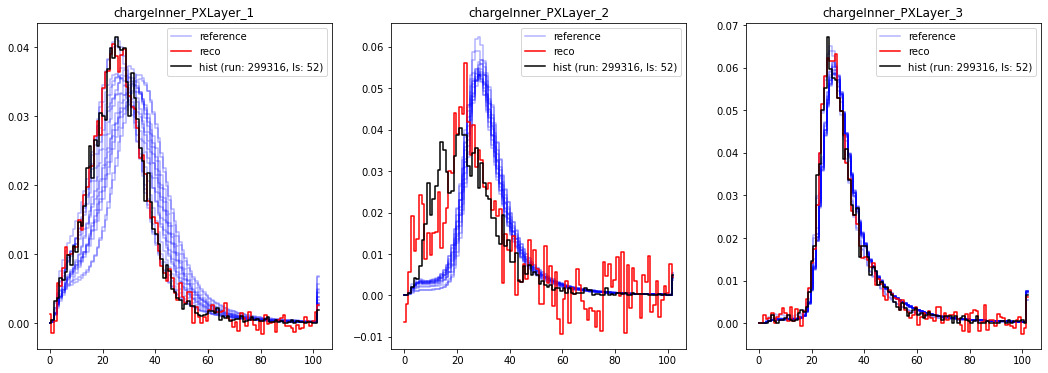

-------------
MSE values:
chargeInner_PXLayer_1 : 1.7757303811055895e-05
chargeInner_PXLayer_2 : 0.00025993053377669576
chargeInner_PXLayer_3 : 2.2607295109415748e-05
-------------
logprob: -270.5102559150921


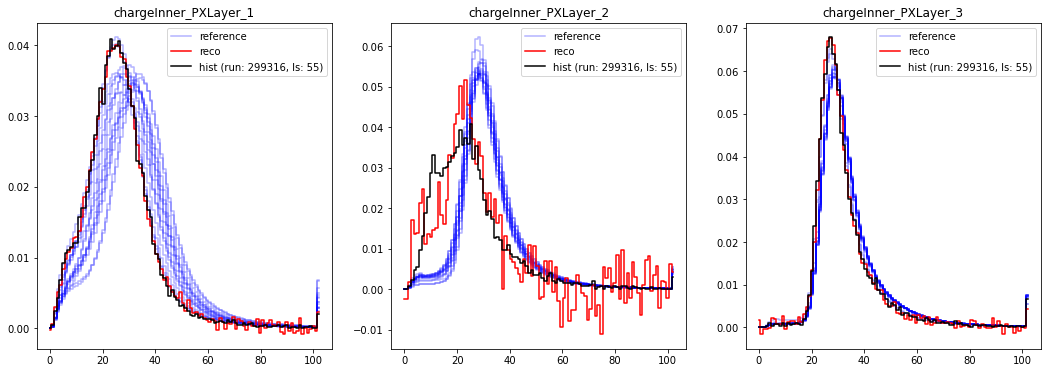

-------------
MSE values:
chargeInner_PXLayer_1 : 3.4560426684125065e-06
chargeInner_PXLayer_2 : 0.00019315993878562445
chargeInner_PXLayer_3 : 7.14882539294893e-06
-------------
logprob: -150.21729868038298


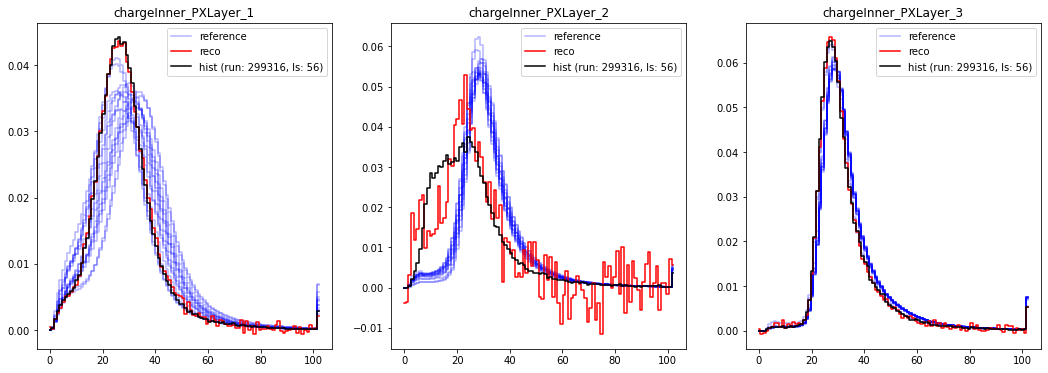

-------------
MSE values:
chargeInner_PXLayer_1 : 1.789930693899339e-06
chargeInner_PXLayer_2 : 0.0002094257449560173
chargeInner_PXLayer_3 : 1.9170032476755643e-06
-------------
logprob: -190.25694422523537


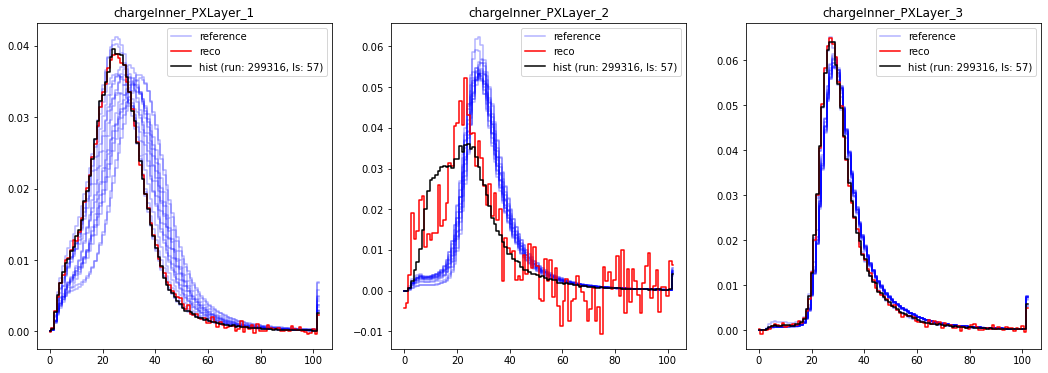

-------------
MSE values:
chargeInner_PXLayer_1 : 7.444761310425895e-07
chargeInner_PXLayer_2 : 0.00019220747375404965
chargeInner_PXLayer_3 : 1.2533553508519298e-06
-------------
logprob: -156.6377501527054


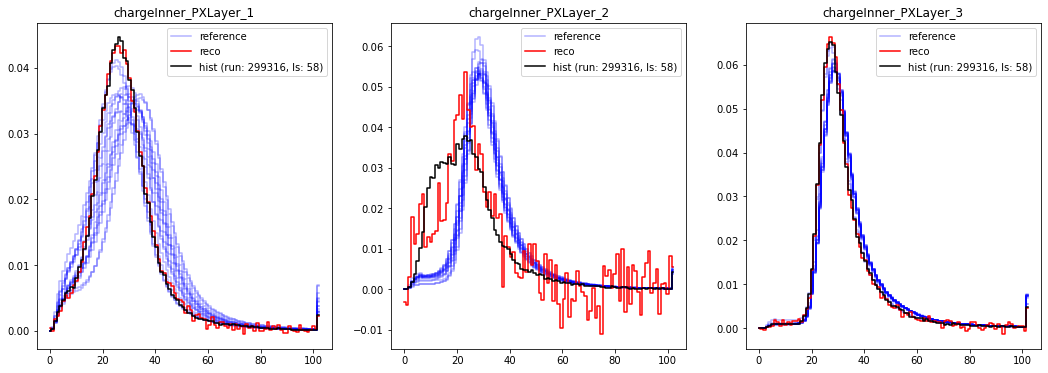

-------------
MSE values:
chargeInner_PXLayer_1 : 2.085153764845641e-06
chargeInner_PXLayer_2 : 0.00020843799742806002
chargeInner_PXLayer_3 : 3.3543211943880417e-06
-------------
logprob: -186.41034910137282


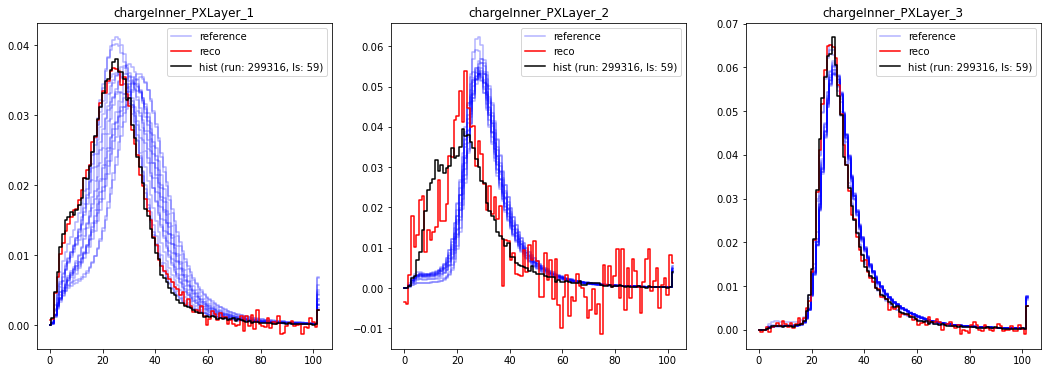

-------------
MSE values:
chargeInner_PXLayer_1 : 2.549325848898426e-06
chargeInner_PXLayer_2 : 0.00019984081565819025
chargeInner_PXLayer_3 : 4.783021687763816e-06
-------------
logprob: -166.57902655955863


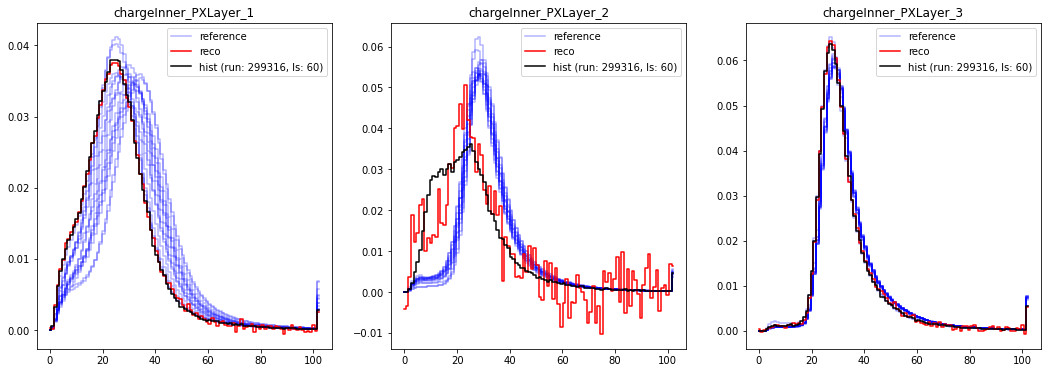

-------------
MSE values:
chargeInner_PXLayer_1 : 8.538847134456738e-07
chargeInner_PXLayer_2 : 0.00018988067987429547
chargeInner_PXLayer_3 : 1.3304129414580007e-06
-------------
logprob: -151.81284757544066


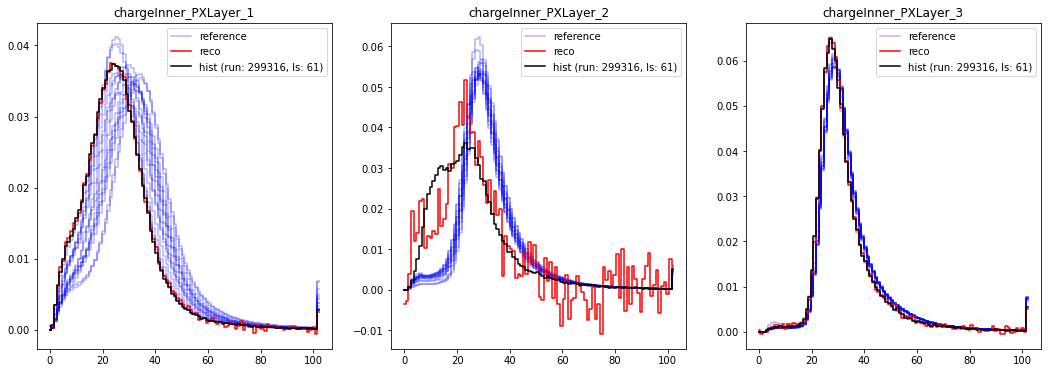

-------------
MSE values:
chargeInner_PXLayer_1 : 7.135551491185922e-07
chargeInner_PXLayer_2 : 0.00018613077849557563
chargeInner_PXLayer_3 : 1.534088305606097e-06
-------------
logprob: -144.55675982046247


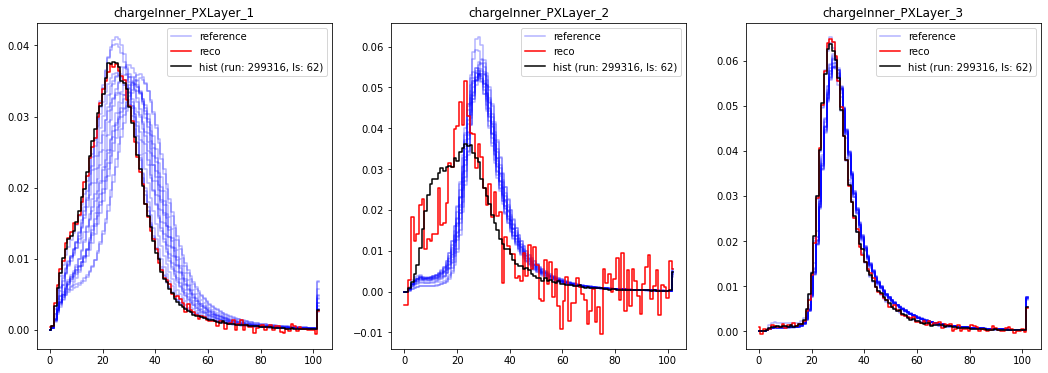

-------------
MSE values:
chargeInner_PXLayer_1 : 1.0946461875609997e-06
chargeInner_PXLayer_2 : 0.0001804403575887638
chargeInner_PXLayer_3 : 1.5015201325235232e-06
-------------
logprob: -133.26411293073403


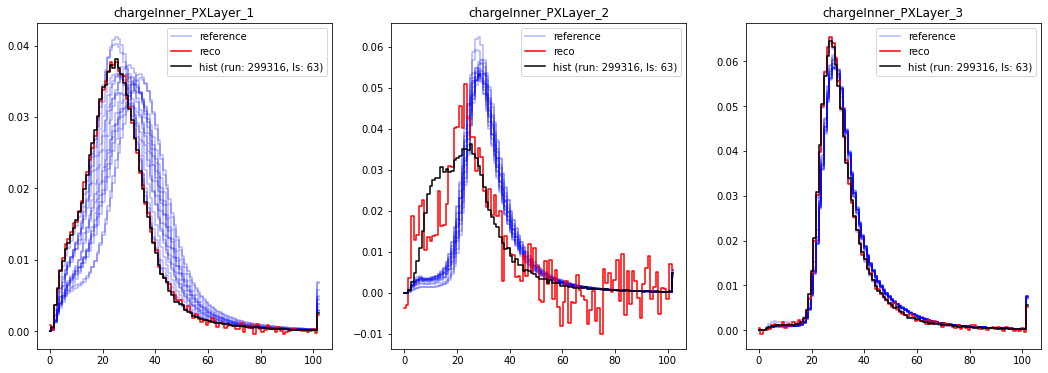

-------------
MSE values:
chargeInner_PXLayer_1 : 7.556895083787623e-07
chargeInner_PXLayer_2 : 0.00018274794567579177
chargeInner_PXLayer_3 : 1.5954627095628938e-06
-------------
logprob: -137.99211884412668


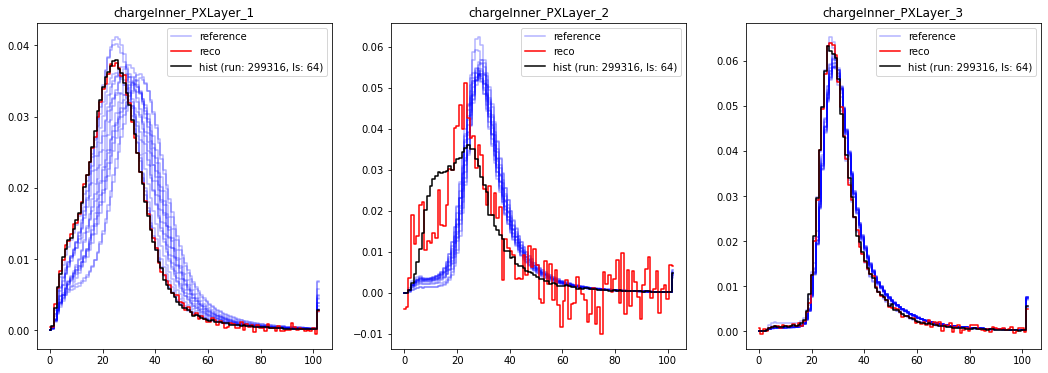

-------------
MSE values:
chargeInner_PXLayer_1 : 6.886280333683583e-07
chargeInner_PXLayer_2 : 0.00018433857440733011
chargeInner_PXLayer_3 : 2.3344695633769136e-06
-------------
logprob: -140.56724618871337


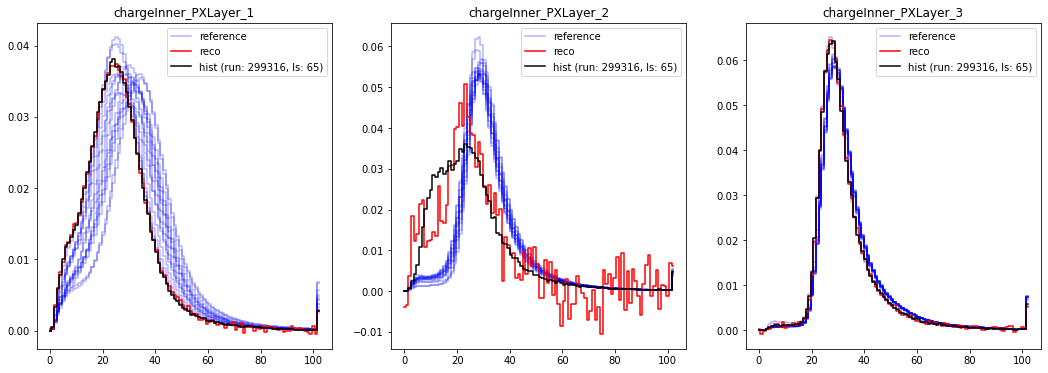

-------------
MSE values:
chargeInner_PXLayer_1 : 6.197119410239517e-07
chargeInner_PXLayer_2 : 0.00017265472397316286
chargeInner_PXLayer_3 : 1.0328277268574011e-06
-------------
logprob: -120.02374498370762


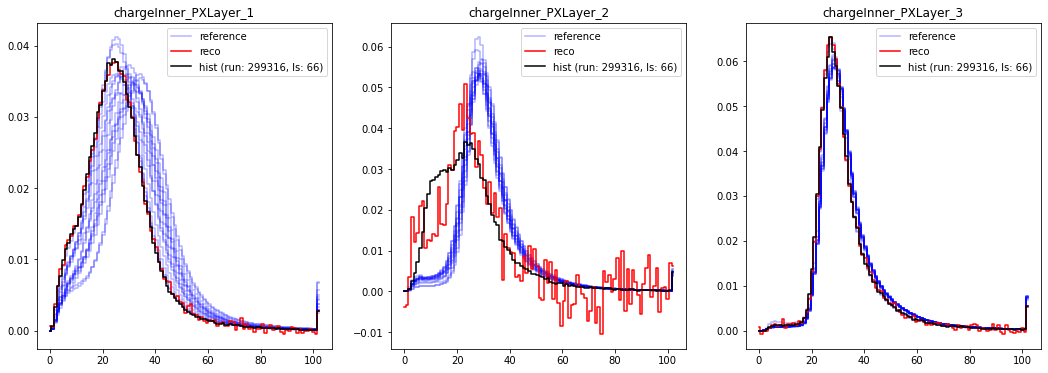

-------------
MSE values:
chargeInner_PXLayer_1 : 1.2380473059851868e-06
chargeInner_PXLayer_2 : 0.00017947766441956756
chargeInner_PXLayer_3 : 2.3447177004494205e-06
-------------
logprob: -130.648327353506


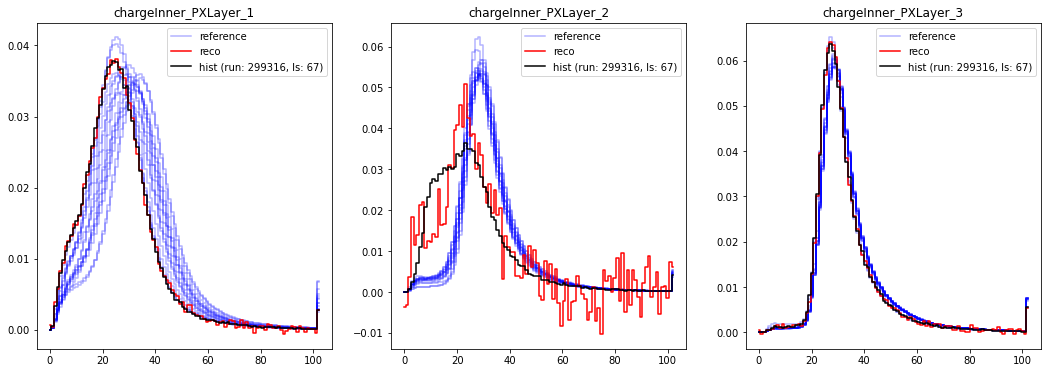

-------------
MSE values:
chargeInner_PXLayer_1 : 1.3937143255690715e-06
chargeInner_PXLayer_2 : 0.00017695961682253226
chargeInner_PXLayer_3 : 1.573130773790262e-06
-------------
logprob: -126.39863400206158


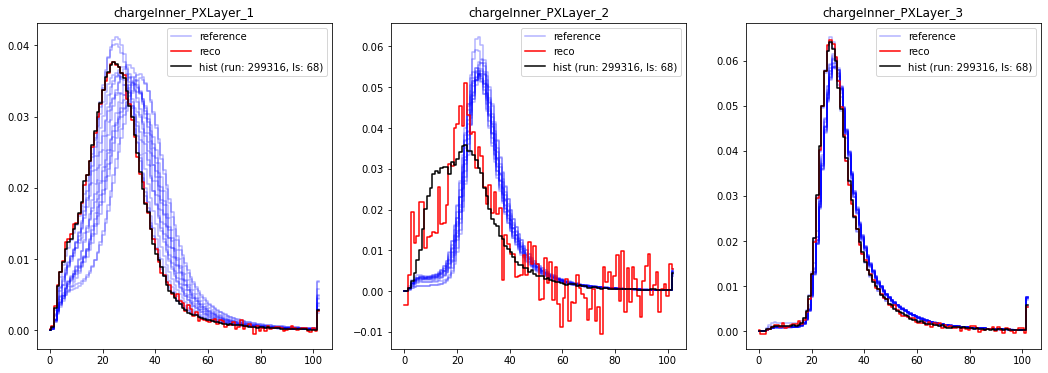

-------------
MSE values:
chargeInner_PXLayer_1 : 8.911418969422349e-07
chargeInner_PXLayer_2 : 0.00018673966559873057
chargeInner_PXLayer_3 : 1.0970093861697062e-06
-------------
logprob: -145.82504851797748


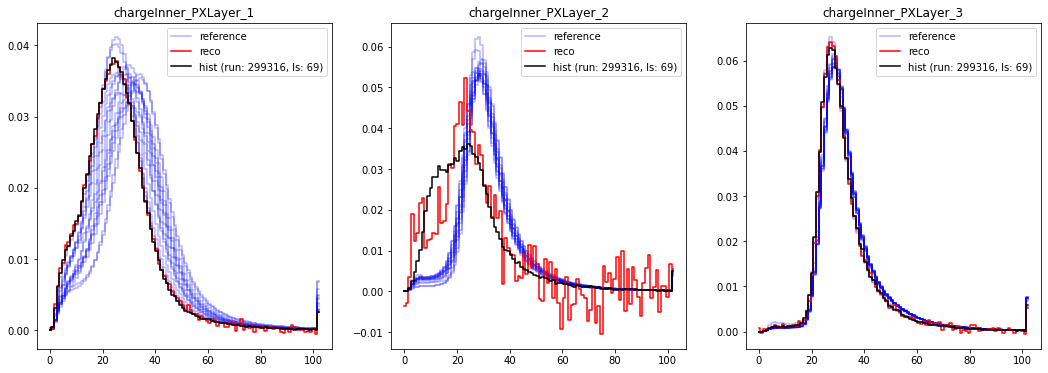

-------------
MSE values:
chargeInner_PXLayer_1 : 7.433166147244316e-07
chargeInner_PXLayer_2 : 0.00018411032042292796
chargeInner_PXLayer_3 : 2.40614909218194e-06
-------------
logprob: -140.000006206285


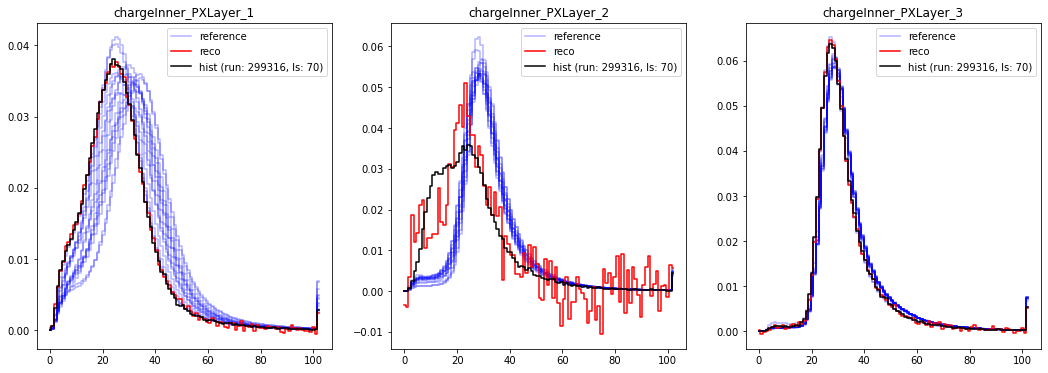

-------------
MSE values:
chargeInner_PXLayer_1 : 7.468269009364594e-07
chargeInner_PXLayer_2 : 0.00018616321601026907
chargeInner_PXLayer_3 : 1.0383099132536884e-06
-------------
logprob: -144.96081563900643


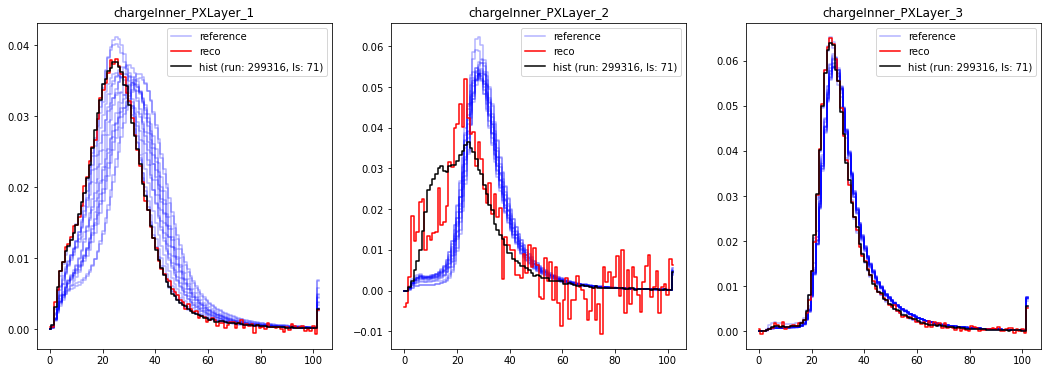

-------------
MSE values:
chargeInner_PXLayer_1 : 1.0423983317460903e-06
chargeInner_PXLayer_2 : 0.00018716218625030153
chargeInner_PXLayer_3 : 1.442867685577985e-06
-------------
logprob: -146.1531380167858


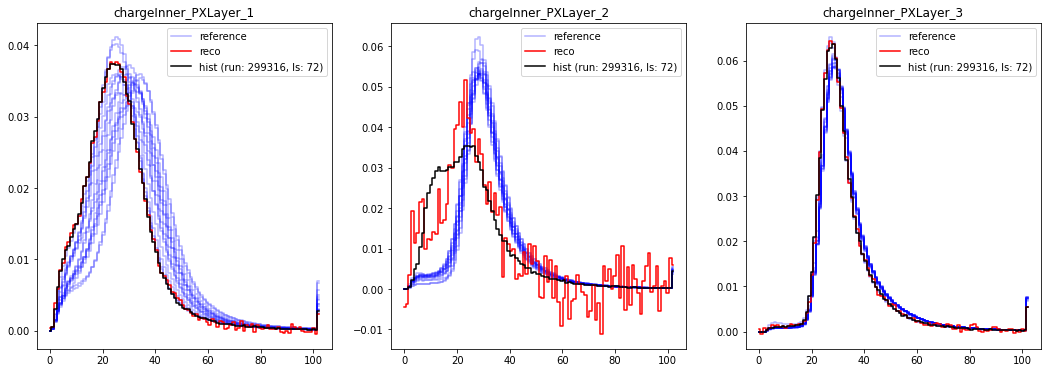

-------------
MSE values:
chargeInner_PXLayer_1 : 6.075695467662263e-07
chargeInner_PXLayer_2 : 0.00019322670548580116
chargeInner_PXLayer_3 : 1.445609037059828e-06
-------------
logprob: -158.72242957003363


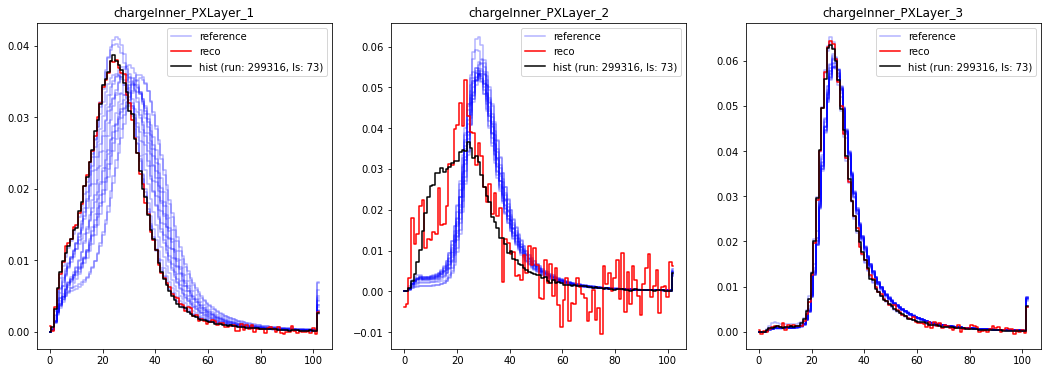

-------------
MSE values:
chargeInner_PXLayer_1 : 8.360470650911e-07
chargeInner_PXLayer_2 : 0.00018195911751016367
chargeInner_PXLayer_3 : 1.069640964954611e-06
-------------
logprob: -136.79645478708917


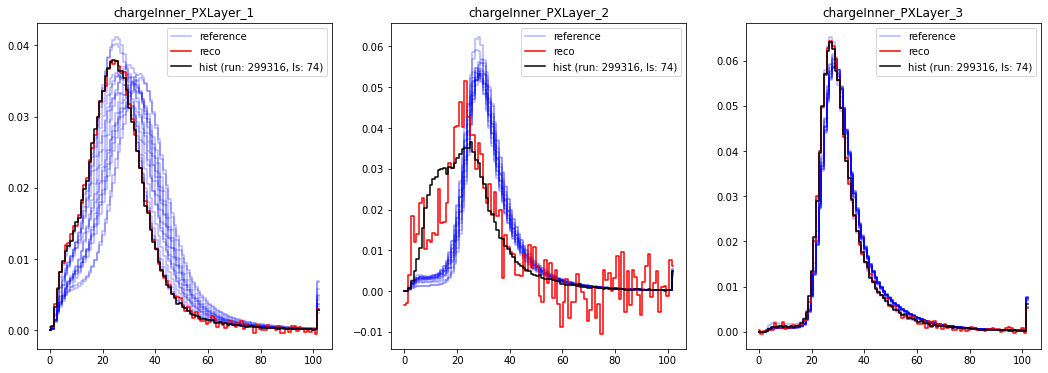

-------------
MSE values:
chargeInner_PXLayer_1 : 8.085360108160207e-07
chargeInner_PXLayer_2 : 0.0001870242581945716
chargeInner_PXLayer_3 : 1.6141394367924394e-06
-------------
logprob: -146.08274236808057


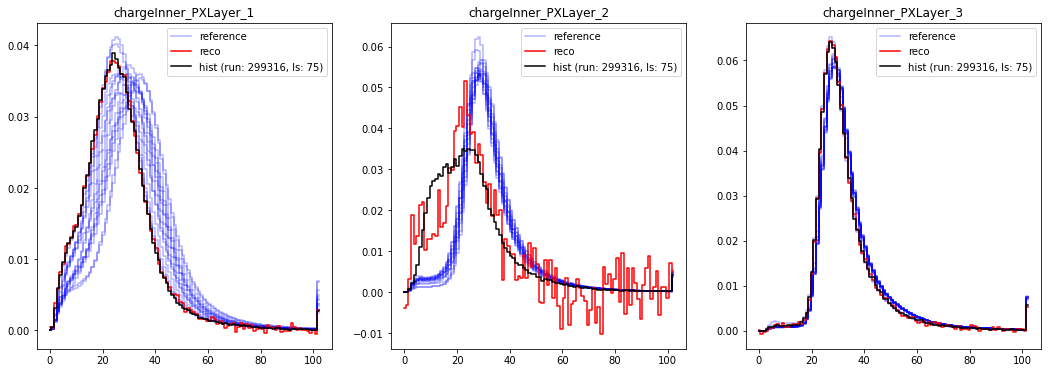

-------------
MSE values:
chargeInner_PXLayer_1 : 8.826890468693007e-07
chargeInner_PXLayer_2 : 0.00018186148258057024
chargeInner_PXLayer_3 : 7.575845475482771e-07
-------------
logprob: -136.79874266370658


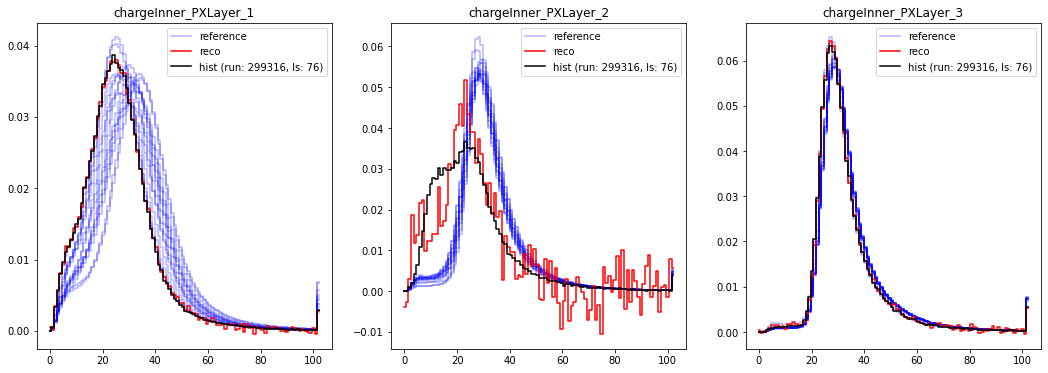

-------------
MSE values:
chargeInner_PXLayer_1 : 6.045898596542051e-07
chargeInner_PXLayer_2 : 0.00017899570389239605
chargeInner_PXLayer_3 : 1.5071416858782786e-06
-------------
logprob: -131.2465519470381


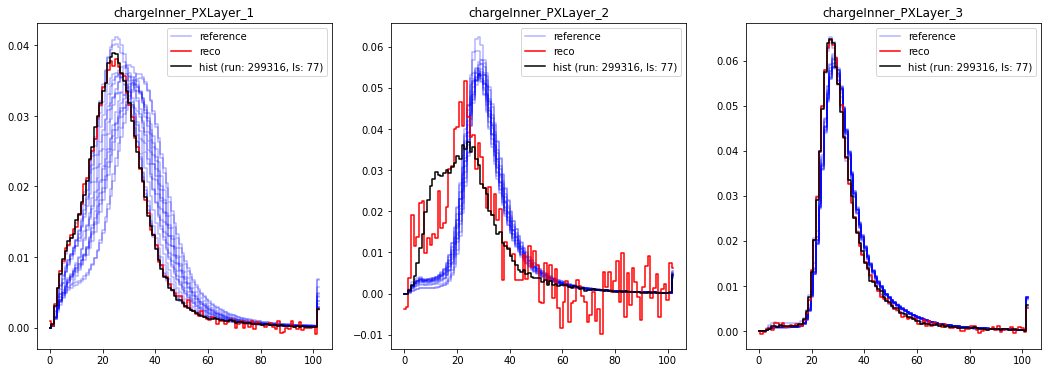

-------------
MSE values:
chargeInner_PXLayer_1 : 1.5117836201973845e-06
chargeInner_PXLayer_2 : 0.00019422696850748562
chargeInner_PXLayer_3 : 1.6841417365733222e-06
-------------
logprob: -159.21921816302395


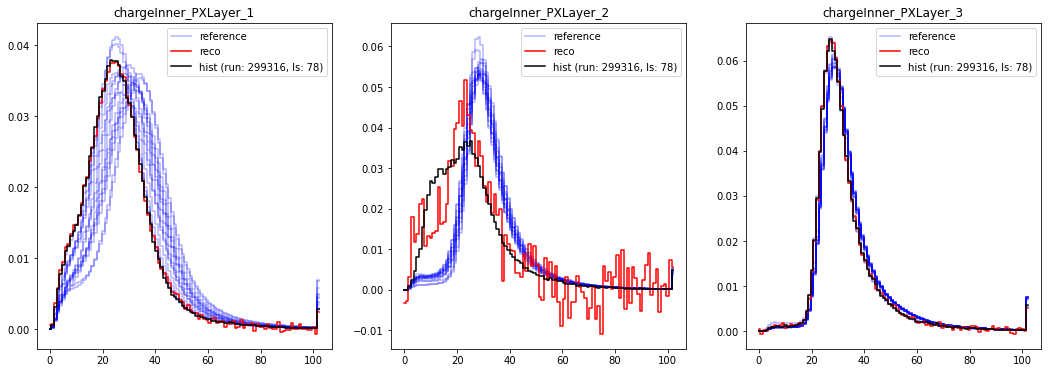

-------------
MSE values:
chargeInner_PXLayer_1 : 8.204502675979438e-07
chargeInner_PXLayer_2 : 0.00017210565291138924
chargeInner_PXLayer_3 : 1.1851477783234774e-06
-------------
logprob: -118.66885533587683


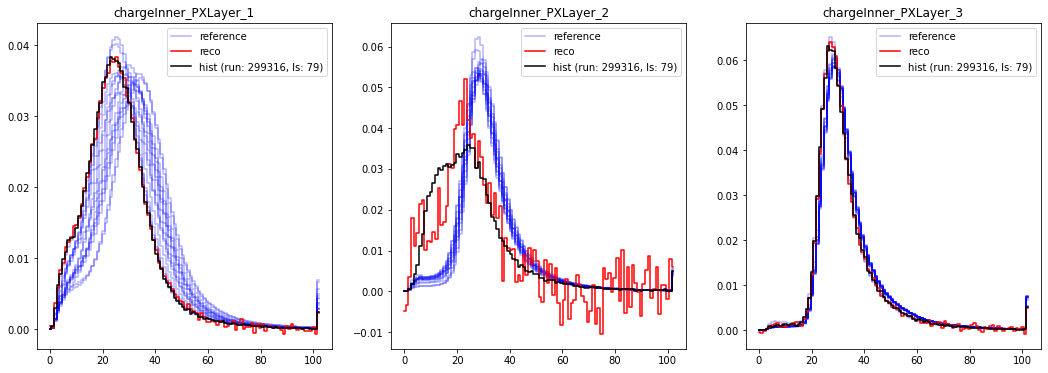

-------------
MSE values:
chargeInner_PXLayer_1 : 1.2773227379122685e-06
chargeInner_PXLayer_2 : 0.0001916838711293074
chargeInner_PXLayer_3 : 2.814277976491882e-06
-------------
logprob: -153.58412975526656


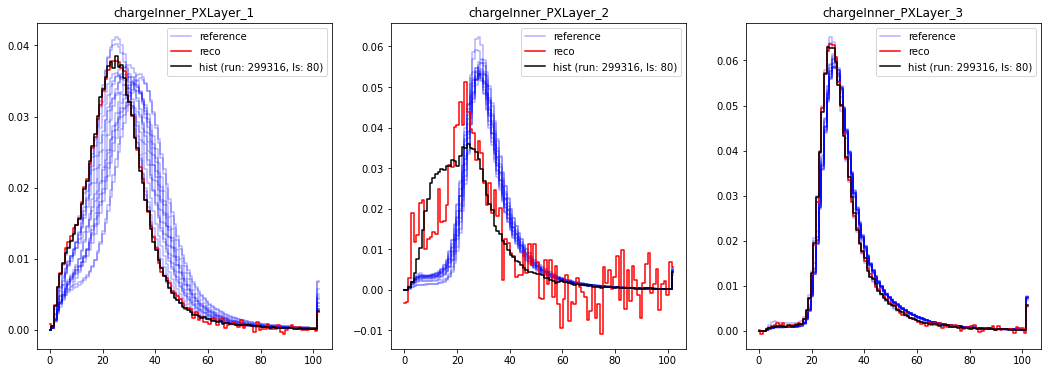

-------------
MSE values:
chargeInner_PXLayer_1 : 7.657982567314344e-07
chargeInner_PXLayer_2 : 0.00018912527541921416
chargeInner_PXLayer_3 : 8.615633295083409e-07
-------------
logprob: -150.838276928487


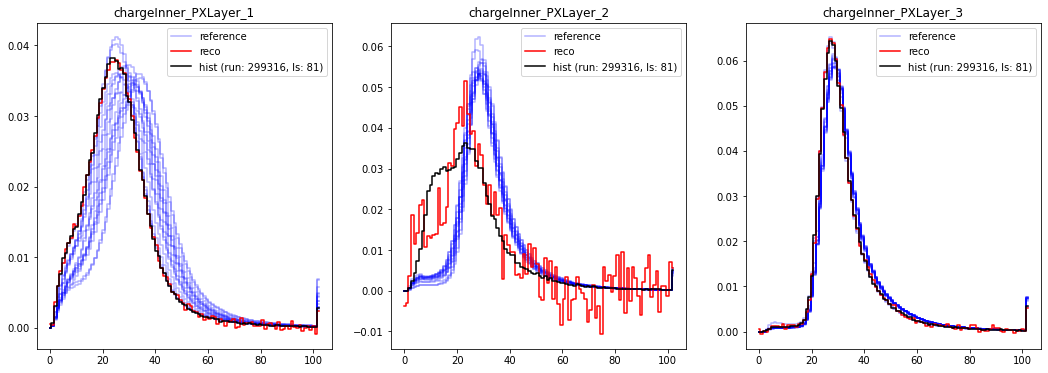

-------------
MSE values:
chargeInner_PXLayer_1 : 7.961240060557635e-07
chargeInner_PXLayer_2 : 0.00018773448213521562
chargeInner_PXLayer_3 : 1.1680827926839877e-06
-------------
logprob: -147.83020186837106


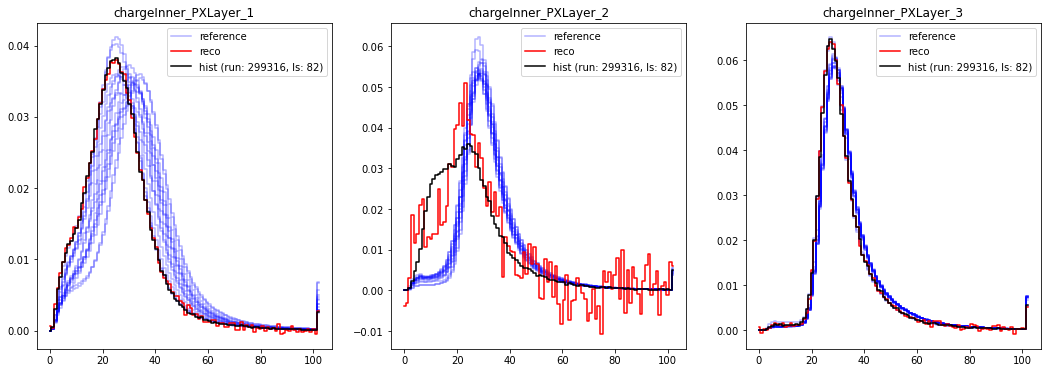

-------------
MSE values:
chargeInner_PXLayer_1 : 9.108114817272354e-07
chargeInner_PXLayer_2 : 0.00018588335849428135
chargeInner_PXLayer_3 : 1.6839485946085694e-06
-------------
logprob: -143.68177471310824


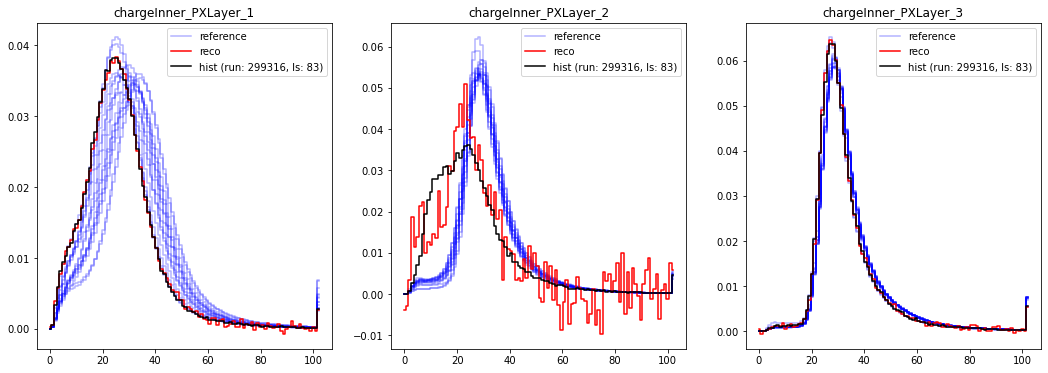

-------------
MSE values:
chargeInner_PXLayer_1 : 9.507886445208876e-07
chargeInner_PXLayer_2 : 0.00018073760709128104
chargeInner_PXLayer_3 : 1.0533657605159981e-06
-------------
logprob: -134.36151799334598


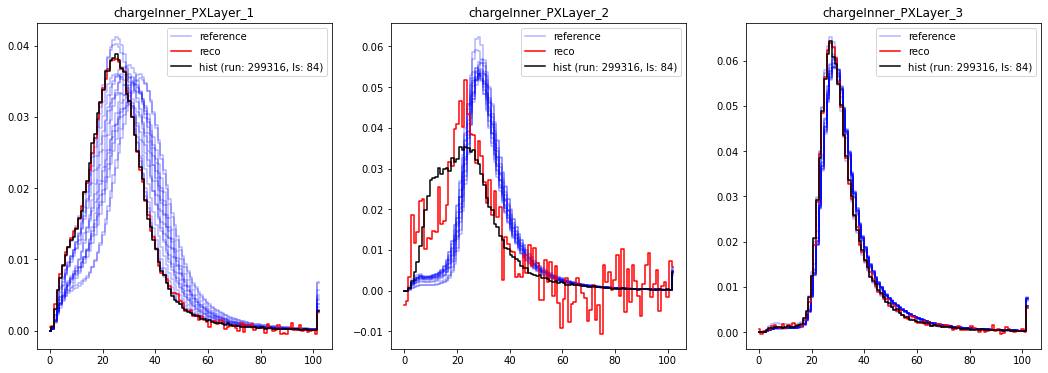

-------------
MSE values:
chargeInner_PXLayer_1 : 1.0356421055160386e-06
chargeInner_PXLayer_2 : 0.00018057697063614402
chargeInner_PXLayer_3 : 1.5547510876334663e-06
-------------
logprob: -133.55705521298282


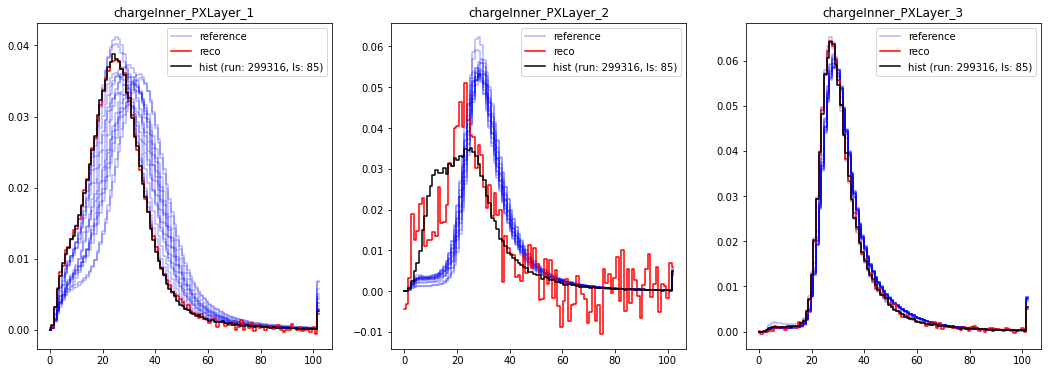

-------------
MSE values:
chargeInner_PXLayer_1 : 6.272427451597368e-07
chargeInner_PXLayer_2 : 0.0001919502237075011
chargeInner_PXLayer_3 : 1.3725263936169325e-06
-------------
logprob: -156.20392521997792


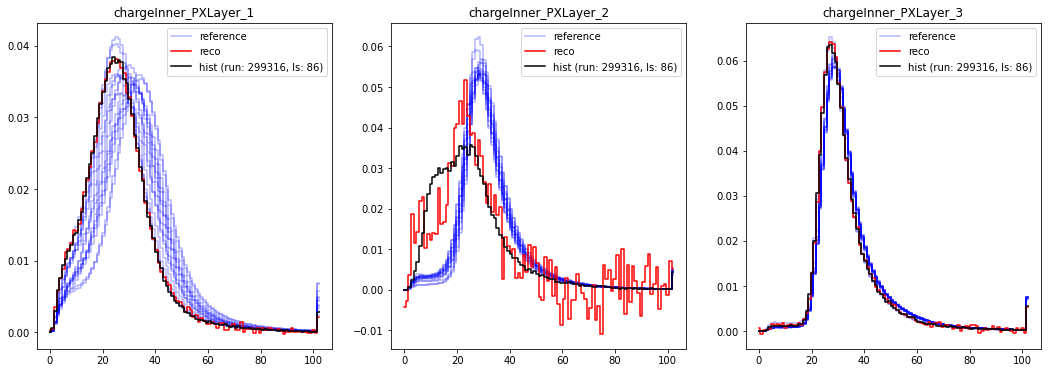

-------------
MSE values:
chargeInner_PXLayer_1 : 9.094754280102449e-07
chargeInner_PXLayer_2 : 0.00018503148455321434
chargeInner_PXLayer_3 : 1.5401105734227105e-06
-------------
logprob: -142.1614361027387


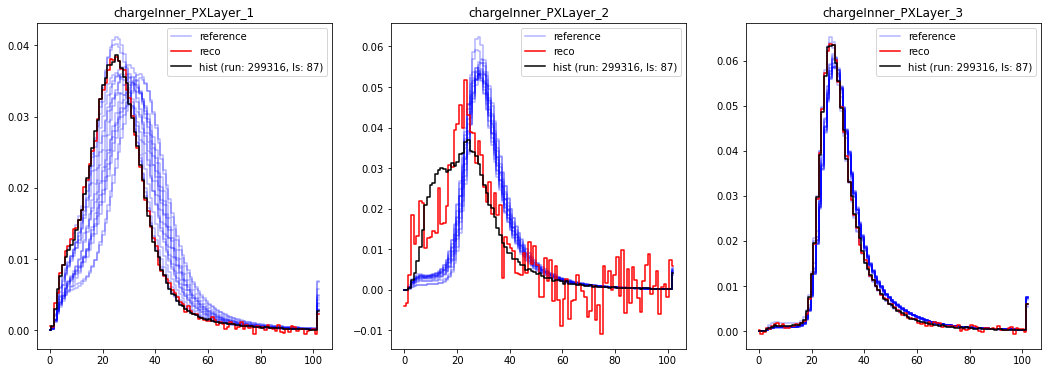

-------------
MSE values:
chargeInner_PXLayer_1 : 1.1169975990271344e-06
chargeInner_PXLayer_2 : 0.00017903951280093063
chargeInner_PXLayer_3 : 8.166548237349151e-07
-------------
logprob: -131.1737002286417


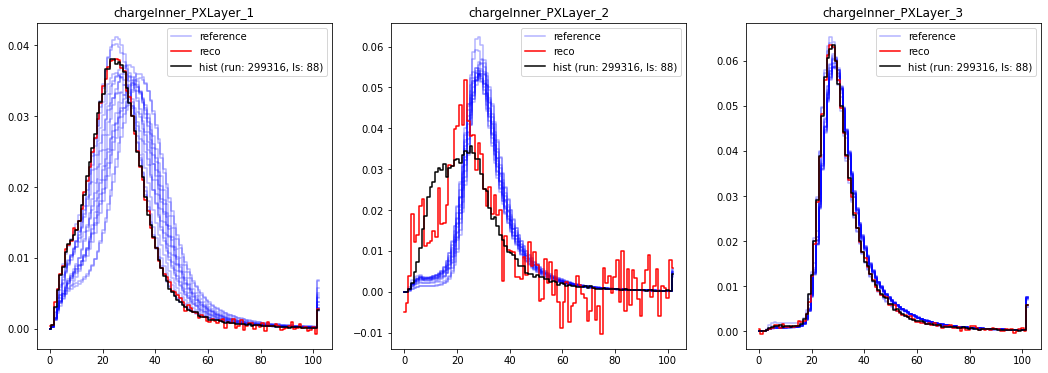

-------------
MSE values:
chargeInner_PXLayer_1 : 9.290446025082345e-07
chargeInner_PXLayer_2 : 0.0001991159627975427
chargeInner_PXLayer_3 : 9.378574186155769e-07
-------------
logprob: -170.63683049677283


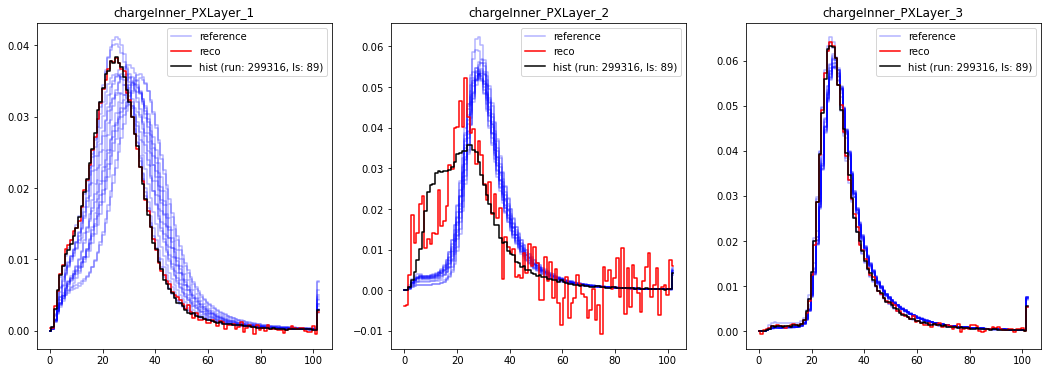

-------------
MSE values:
chargeInner_PXLayer_1 : 8.058066798139237e-07
chargeInner_PXLayer_2 : 0.0001920398176080533
chargeInner_PXLayer_3 : 1.08459909780729e-06
-------------
logprob: -156.35312088722637


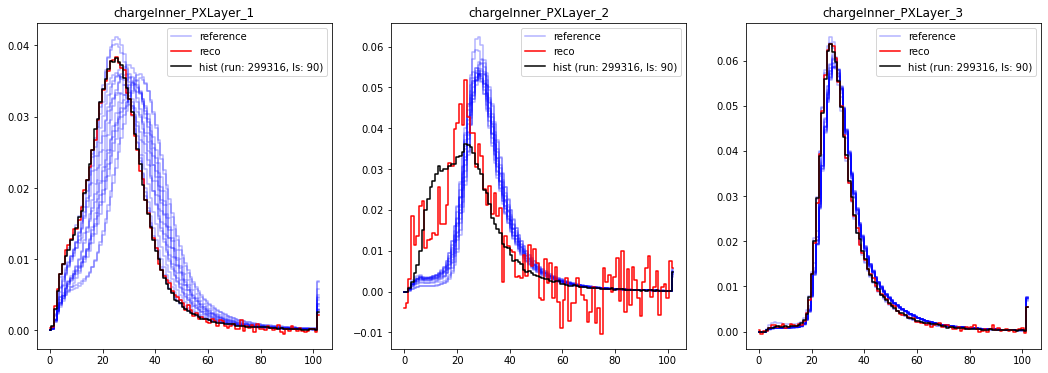

-------------
MSE values:
chargeInner_PXLayer_1 : 9.353568085053938e-07
chargeInner_PXLayer_2 : 0.00017930863625771675
chargeInner_PXLayer_3 : 1.0724569080725643e-06
-------------
logprob: -131.70416498894136


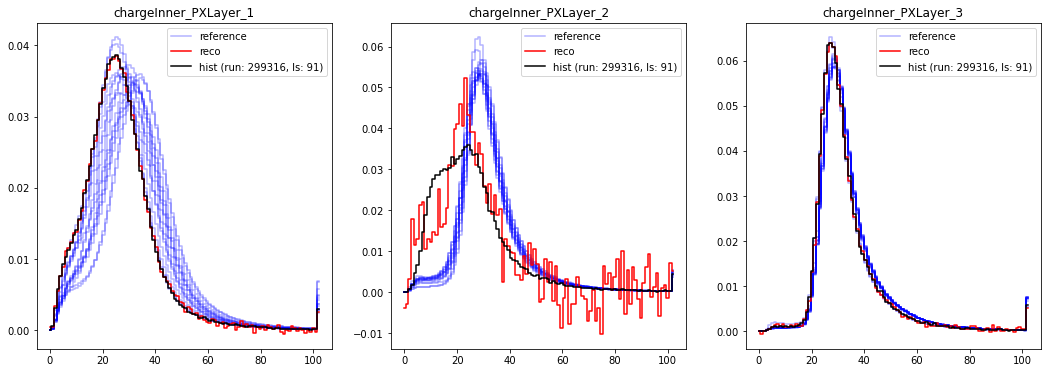

-------------
MSE values:
chargeInner_PXLayer_1 : 6.75284206067677e-07
chargeInner_PXLayer_2 : 0.00018779616009708728
chargeInner_PXLayer_3 : 1.3264977899614782e-06
-------------
logprob: -147.99797690284865


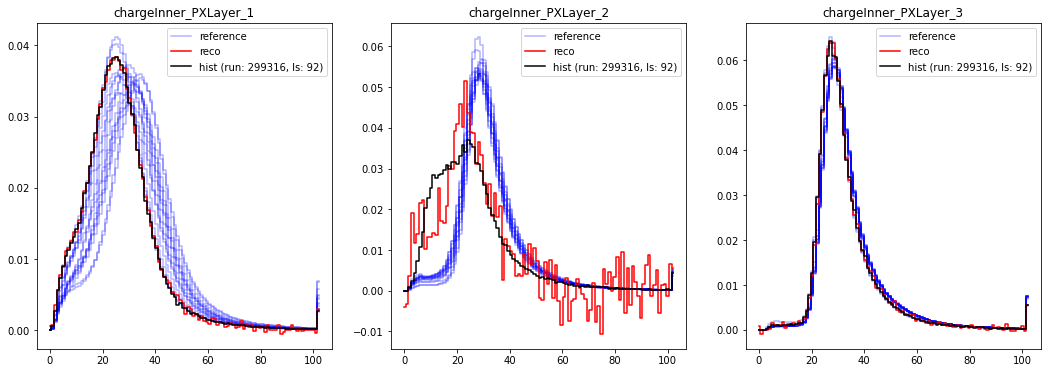

-------------
MSE values:
chargeInner_PXLayer_1 : 8.556393397650946e-07
chargeInner_PXLayer_2 : 0.000185057805198415
chargeInner_PXLayer_3 : 2.0098417752818183e-06
-------------
logprob: -141.93053372835354


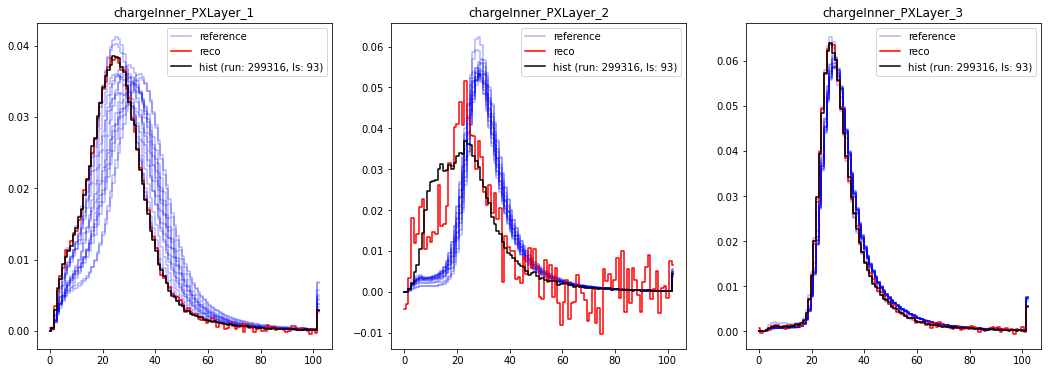

-------------
MSE values:
chargeInner_PXLayer_1 : 6.890438025246668e-07
chargeInner_PXLayer_2 : 0.0001814290142067259
chargeInner_PXLayer_3 : 1.184019893810595e-06
-------------
logprob: -135.91213531168674


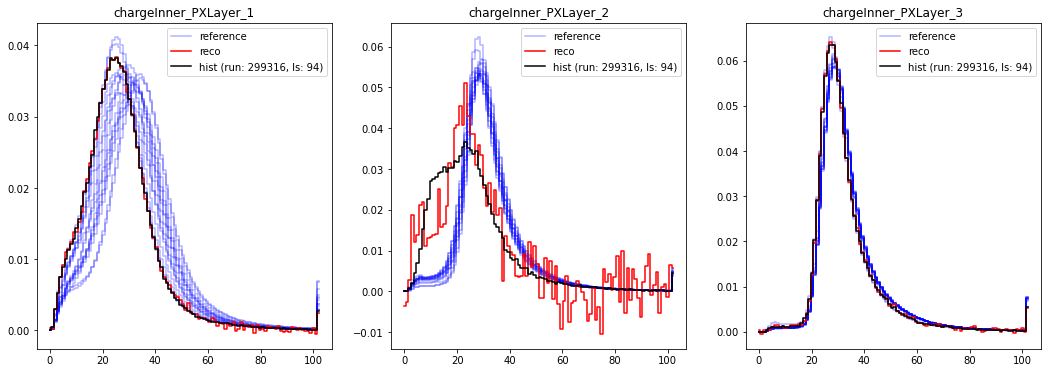

-------------
MSE values:
chargeInner_PXLayer_1 : 9.502161304373086e-07
chargeInner_PXLayer_2 : 0.00018300549724961507
chargeInner_PXLayer_3 : 5.520518072024334e-07
-------------
logprob: -139.04090089304552


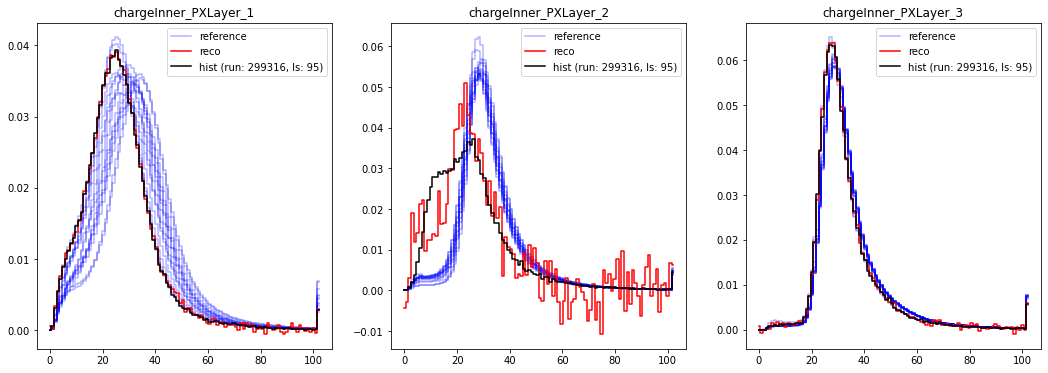

-------------
MSE values:
chargeInner_PXLayer_1 : 7.781335120658856e-07
chargeInner_PXLayer_2 : 0.00018706748843657947
chargeInner_PXLayer_3 : 1.5652169211109869e-06
-------------
logprob: -146.24831860633023


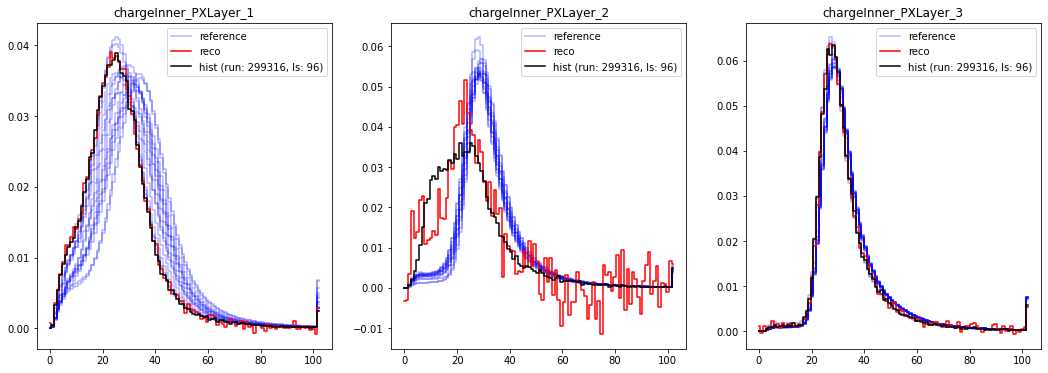

-------------
MSE values:
chargeInner_PXLayer_1 : 2.2918460446815278e-06
chargeInner_PXLayer_2 : 0.00018895411763866017
chargeInner_PXLayer_3 : 4.003111068540361e-06
-------------
logprob: -145.90508277258797


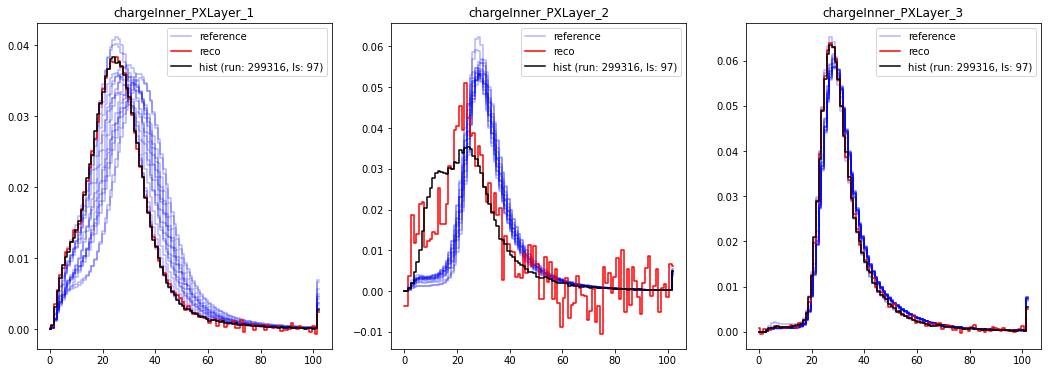

-------------
MSE values:
chargeInner_PXLayer_1 : 8.683085284590704e-07
chargeInner_PXLayer_2 : 0.00017731047679984675
chargeInner_PXLayer_3 : 1.096437654566462e-06
-------------
logprob: -128.08590644102506


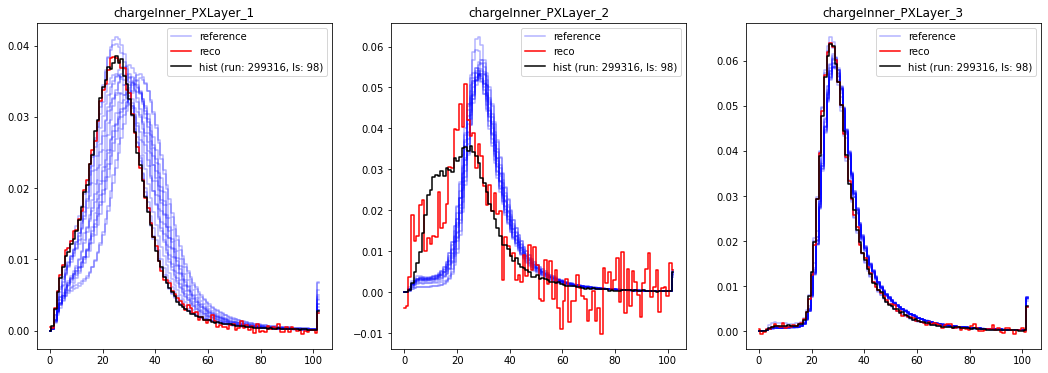

-------------
MSE values:
chargeInner_PXLayer_1 : 1.2567017754128273e-06
chargeInner_PXLayer_2 : 0.00018767932274157682
chargeInner_PXLayer_3 : 7.876663048455044e-07
-------------
logprob: -147.41107159418922


In [24]:
### investigate particular lumisections

run = 299316
ls = 89 # ignored if mode is 'run'
masknames = ['dcson'] # ignored if mode is 'ls'
mode = 'run'

#print(histstruct.runnbs[:10])
#print(histstruct.lsnbs[:10])

# define reference histograms
refhists = {}
for histname in histstruct.histnames:
    if( 'good' in histstruct.masks.keys() ): 
        #refhists[histname] = histstruct.get_histograms(masknames=['highstat','dcson','good'])
        refhists[histname] = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['highstat','dcson','good']), 15 )
    else: 
        refhists[histname] = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat'] ), 15 )

if mode=='ls':
    # plot this particular run/ls
    _ = histstruct.plot_ls( run, ls, recohist='auto', refhists=refhists )
    msepoint = histstruct.get_scores_ls( run, ls )
    msepointarray = np.array([msepoint[histname] for histname in histstruct.histnames])
    logprob = np.log(fitfunc.pdf(np.array([msepointarray])))
    print('-------------')
    print('MSE values:')
    for histname in histstruct.histnames: print('{} : {}'.format(histname,msepoint[histname]))
    print('-------------')
    print('logprob: '+str(logprob))

if mode=='run':
    # plot given run
    runnbs = histstruct.get_runnbs( masknames=['dcson'] )
    lsnbs = histstruct.get_lsnbs( masknames=['dcson'] )
    runsel = np.where(runnbs==run)
    lsnbs = lsnbs[runsel]
    print('plotting {} lumisections...'.format(len(lsnbs)))
    for lsnb in lsnbs:
        fig,ax = histstruct.plot_ls(run, lsnb, recohist='auto', refhists=refhists )
        plt.show()
        msepoint = histstruct.get_scores_ls( run, lsnb )
        msepointarray = np.array([msepoint[histname] for histname in histstruct.histnames])
        logprob = np.log(fitfunc.pdf(np.array([msepointarray])))
        print('-------------')
        print('MSE values:')
        for histname in histstruct.histnames: print('{} : {}'.format(histname,msepoint[histname]))
        print('-------------')
        print('logprob: '+str(logprob))

In [25]:
### investigate OMS data: get data

import sys
sys.path.append('../omsapi')
from get_oms_data import get_oms_api,get_oms_data,get_oms_response_attribute
# get the api instance
omsapi = get_oms_api()
# pileup and luminosity in good test set
oms_target_run = 306458
oms_info = get_oms_data( omsapi, 'lumisections', oms_target_run, attributes=['lumisection_number','pileup','delivered_lumi','recorded_lumi'] )
# L1 and HLT rates in good test set
oms_info_l1 = get_oms_data( omsapi, 'l1triggerrates', oms_target_run, extraargs={'group[granularity]':'lumisection'} )
path_filter = {'attribute_name':'path_name','value':'HLT_ZeroBias_v5','operator':'EQ'}
oms_info_hlt = get_oms_data( omsapi, 'hltpathrates', oms_target_run, extraargs={'group[granularity]':'lumisection'}, extrafilters=[path_filter] )

ModuleNotFoundError: No module named 'clientid'

In [26]:
### investigate OMS data: make plots

importlib.reload(pu)

oms_lsnbs = get_oms_response_attribute(oms_info,'lumisection_number')
oms_dcson = jsonu.isdcson( [oms_target_run]*len(oms_lsnbs), oms_lsnbs )
pileup = get_oms_response_attribute(oms_info,'pileup')
lumi_del = get_oms_response_attribute(oms_info,'delivered_lumi')
lumi_rec = get_oms_response_attribute(oms_info,'recorded_lumi')
l1_rate = get_oms_response_attribute(oms_info_l1,'l1a_physics')
l1_rate = [el['rate'] for el in l1_rate]
l1_lsnbs = get_oms_response_attribute(oms_info_l1,'first_lumisection_number') # can differ from oms_lsnbs since some lumisection numbers can be missing apparently
l1_rate = [(l1_rate[l1_lsnbs.index(i)] if i in l1_lsnbs else None) for i in oms_lsnbs]
hlt_rate = get_oms_response_attribute(oms_info_hlt,'rate')
hlt_lsnbs = get_oms_response_attribute(oms_info_hlt,'first_lumisection_number') # can differ from oms_lsnbs since some lumisection numbers can be missing apparently
hlt_rate = [(hlt_rate[hlt_lsnbs.index(i)] if i in hlt_lsnbs else None) for i in oms_lsnbs]


doslice = False
if doslice:
    cropslice=slice(855,865,None)
    oms_lsnbs = oms_lsnbs[cropslice]
    oms_dcson = oms_dcson[cropslice]
    pileup = pileup[cropslice]
    lumi_rec = lumi_rec[cropslice]
    lumi_del = lumi_del[cropslice]
    l1_rate = l1_rate[cropslice]
    hlt_rate = hlt_rate[cropslice]
    
_ = pu.plot_hists([pileup], colorlist=['b'], labellist=['pileup'], 
              xlims=(oms_lsnbs[0],oms_lsnbs[-1]),
              title='pileup for run {}'.format(oms_target_run), xaxtitle='lumisection number', yaxtitle='pileup',
              bkgcolor=oms_dcson,bkgcmap='cool')
_ = pu.plot_hists([lumi_rec,lumi_del], colorlist=['g','b'], labellist=['recorded luminosity','delivered luminosity'],
              xlims=(oms_lsnbs[0],oms_lsnbs[-1]),
              title='luminosity for run {}'.format(oms_target_run), xaxtitle='lumisection number', yaxtitle='luminosity',
              bkgcolor=oms_dcson,bkgcmap='cool')
_ = pu.plot_hists([l1_rate], colorlist=['b'], labellist=['L1 trigger rate'], 
              xlims=(oms_lsnbs[0],oms_lsnbs[-1]),
              title='L1 trigger rate for run {}'.format(oms_target_run), xaxtitle='lumisection number', yaxtitle='rate',
              bkgcolor=oms_dcson,bkgcmap='cool')
_ = pu.plot_hists([hlt_rate], colorlist=['b'], labellist=['HLT trigger rate'], 
              xlims=(oms_lsnbs[0],oms_lsnbs[-1]),
              title='HLT trigger rate for run {}'.format(oms_target_run), xaxtitle='lumisection number', yaxtitle='rate',
              bkgcolor=oms_dcson,bkgcmap='cool')

#lsnb = 20
#idx_oms = np.where(np.array(oms_lsnbs)==lsnb)[0][0]
#print('average pileup for this lumisection: {}'.format(pileup[idx_oms]))

NameError: name 'get_oms_response_attribute' is not defined

found mse array for evaluation set of following shape: (24147, 3)
[29.87253108 29.83313602 30.064      ... 33.5829409  33.56307378
 33.55320446]
24147 out of 24147 LS are within these boundaries
------------------------
------------------------
------------------------
------------------------
------------------------
------------------------
------------------------
------------------------
------------------------
------------------------
maximum number of plots reached


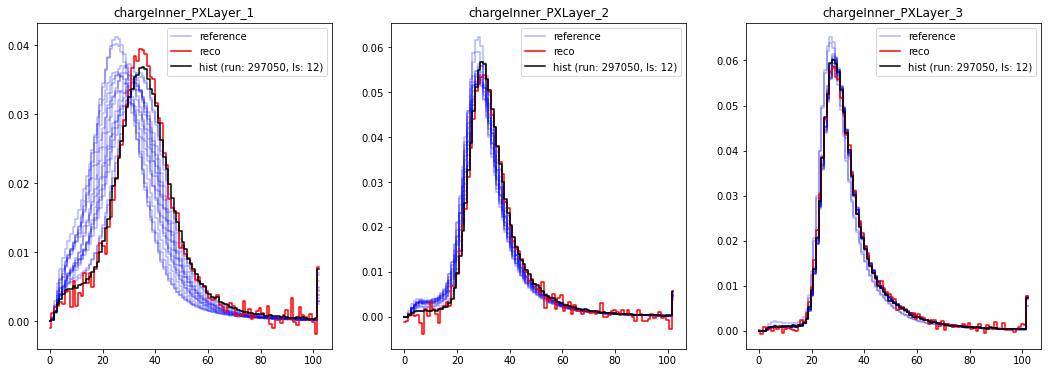

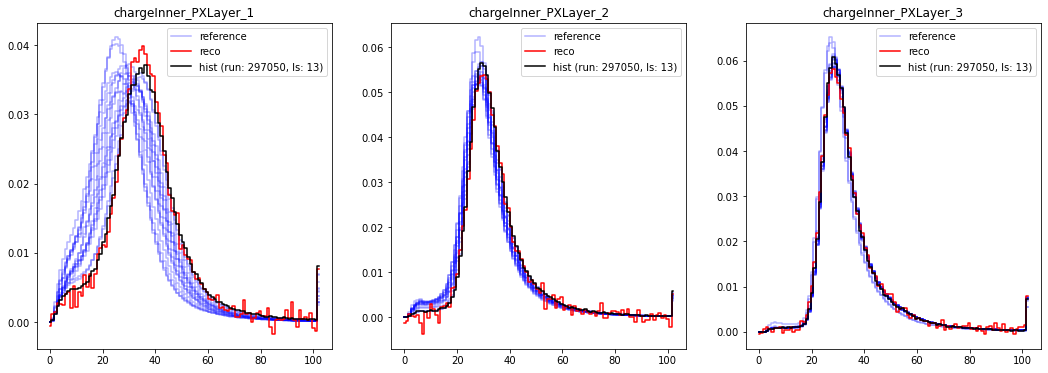

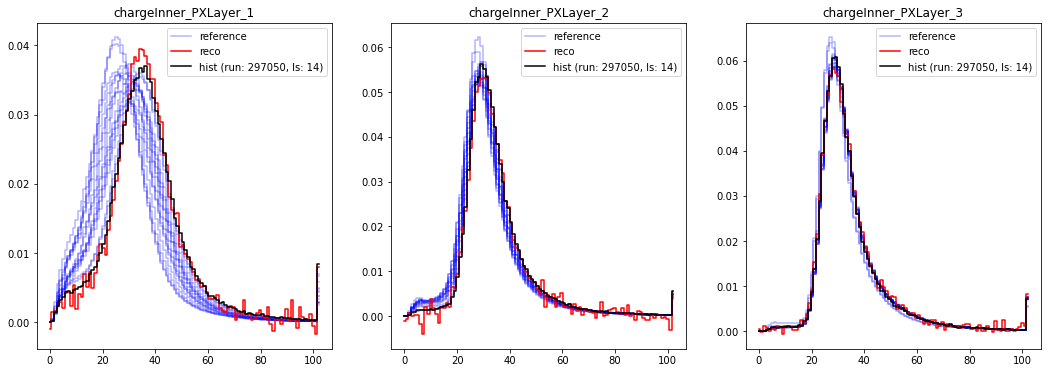

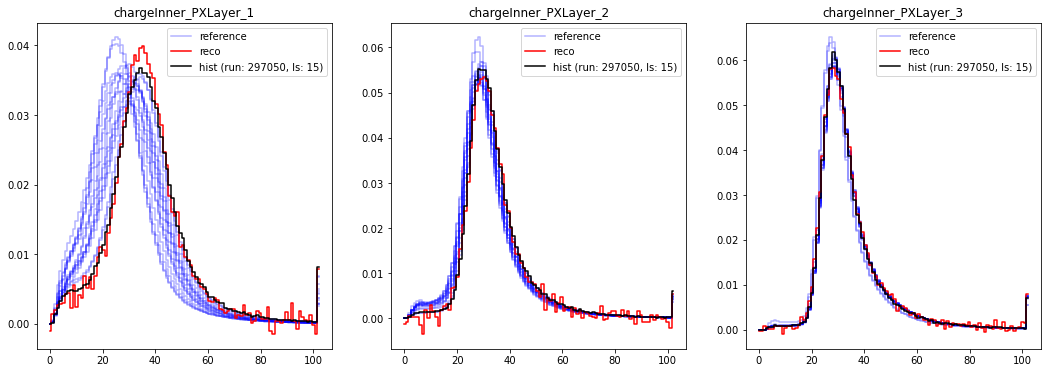

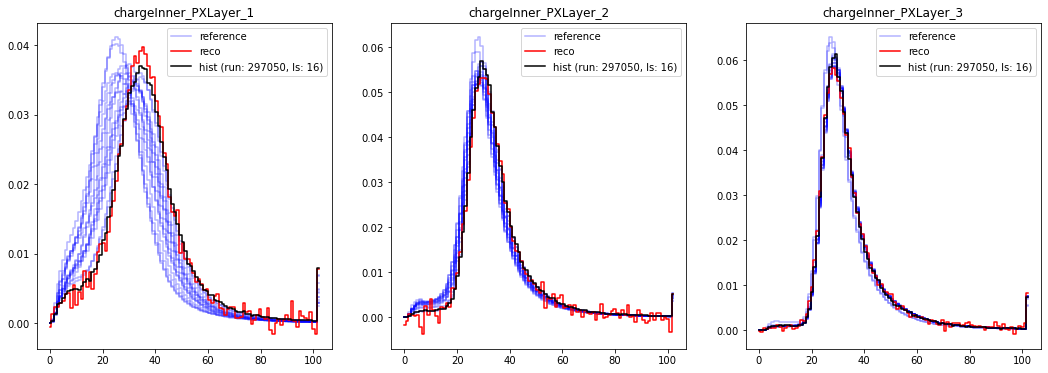

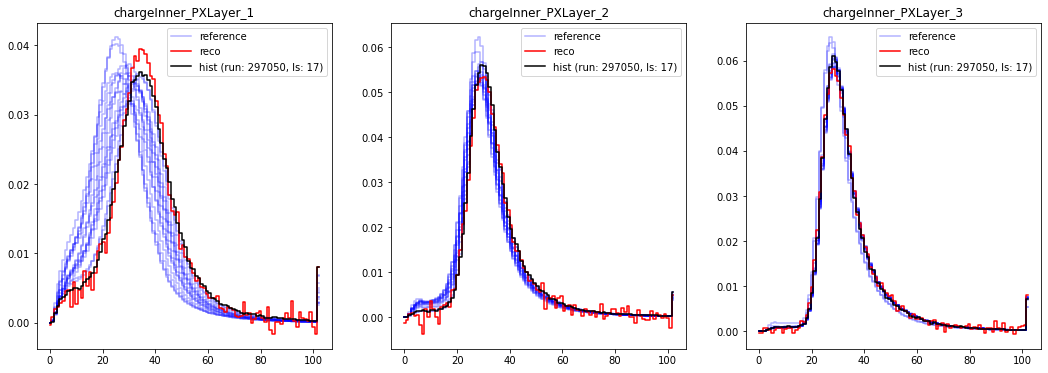

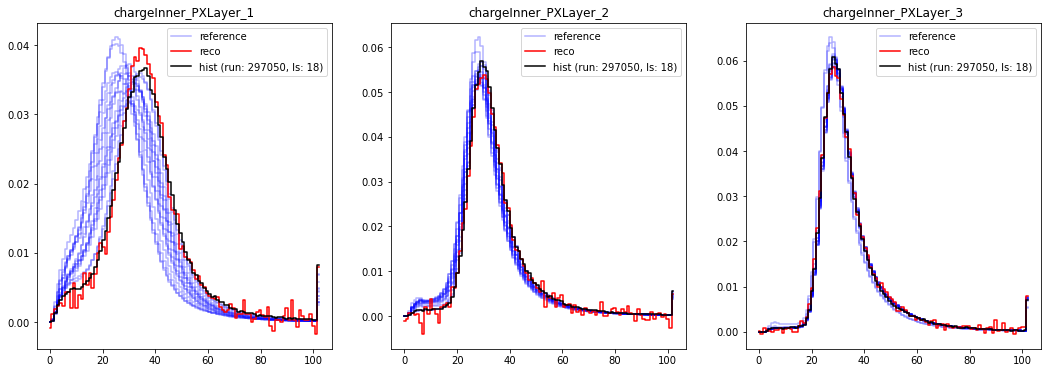

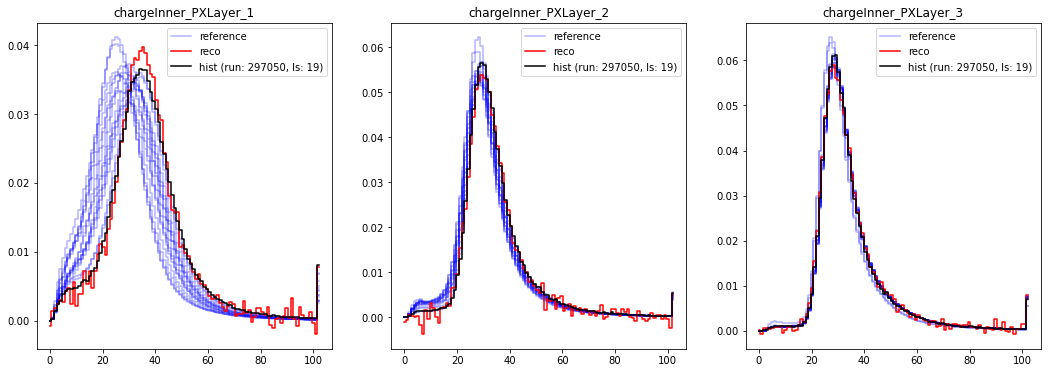

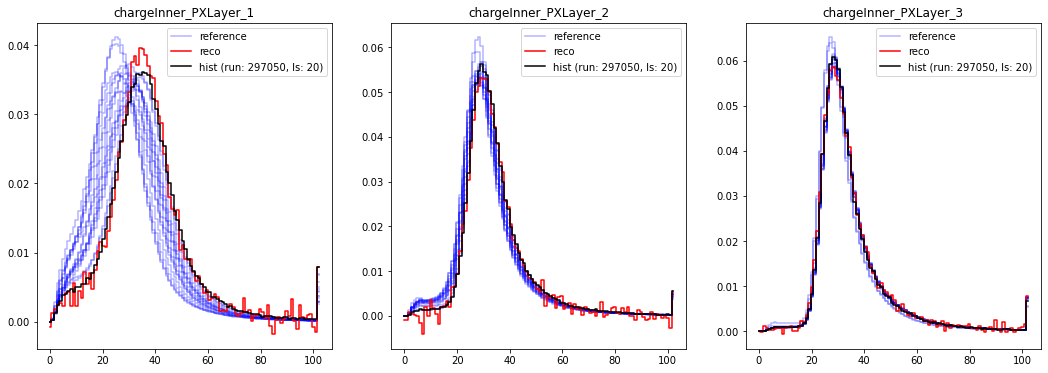

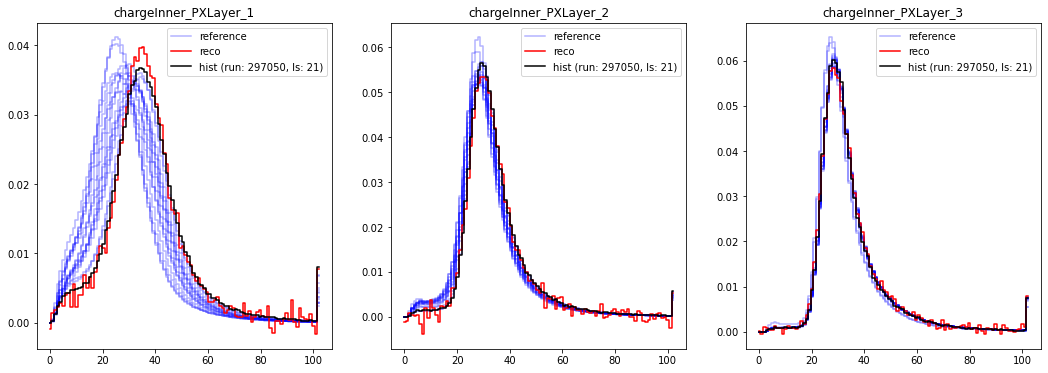

In [27]:
### investigate how the method performs on the golden/custom test set

#evaljson = jsonu.loadjson('utils/json_pixel_good_201201.json')
#histstruct.add_json_mask( 'pixelgood', evaljson )
masks_eval = ['golden', 'highstat']
lsnbs_eval = histstruct.get_lsnbs( masknames=masks_eval )
runnbs_eval = histstruct.get_runnbs( masknames=masks_eval )
mse_eval_dict = histstruct.get_scores( masknames=masks_eval )
mse_eval = []
for histname in histstruct.histnames:
    mse_eval.append( mse_eval_dict[histname] )
mse_eval = np.array(mse_eval)
mse_eval = np.transpose(mse_eval)
print('found mse array for evaluation set of following shape: {}'.format(mse_eval.shape))
logprob_eval = np.log(fitfunc.pdf(mse_eval))
print(logprob_eval)

def get_runsls_inrange(logprob,runnbs,lsnbs,logprob_up=None,logprob_down=None):
    # get a list of tuples of (run number, ls number) corresponding to ls with log probability within a given range
    # - logprob, runnbs and lsnbs are equally long 1D arrays
    # - logprob_up and logprob_down are upper and lower thresholds
    #     if both are not None, the lumisections with logprob between the boundaries are returned
    #     if logprob_up is None, the lumisections with logprob > logprob_down are returned
    #     if logprob_down is None, the lumisections with logprob < logprob_up are returned
    indices = np.array([])
    if logprob_down is None:
        indices = np.nonzero(logprob<logprob_up)[0]
    elif logprob_up is None:
        indices = np.nonzero(logprob>logprob_down)[0]
    else:
        indices = np.nonzero((logprob>logprob_down) & (logprob<logprob_up))[0]
    runsinrange = runnbs[indices]
    lsinrange = lsnbs[indices]
    runslsinrange = []
    for rr,lsr in zip(runsinrange,lsinrange):
        runslsinrange.append((int(rr),int(lsr)))
    return {'indices':indices,'runslsinrange':runslsinrange}

logup = 90
logdown = None
temp = get_runsls_inrange(logprob_eval, runnbs_eval, lsnbs_eval,
                          logprob_up = logup, logprob_down = logdown)

runslsinrange = temp['runslsinrange']
print('{} out of {} LS are within these boundaries'.format(len(runslsinrange),len(logprob_eval)))

# make plots
nplotsmax = 10
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('test.pdf')
for i,(runnb,lsnb) in enumerate(runslsinrange):
    if i>=nplotsmax:
        print('maximum number of plots reached')
        break
    print('------------------------')
    _ = histstruct.plot_ls( runnb, lsnb, recohist='auto', refhists=refhists)
    fig.show()
    pdf.savefig(fig)
    # only for 2 dimensions: extra contour plot
    #if nhisttypes != 2: continue
    #fig,ax = plt.subplots()
    #contourplot = ax.contourf(x, y, np.log(fitfunc.pdfgrid(pos)))
    #plt.colorbar(contourplot)
    #ax.plot(msepoint[0],msepoint[1],'.k',markersize=10)
    #ax.set_xlim((0.,xlim))
    #ax.set_ylim((0.,ylim))
pdf.close()